# Language in Space

## Session 09: file formats; raster data; map making; projections

### Gerhard Jäger

December 23, 2021


In [ ]:
options(repr.plot.width=12, repr.plot.height=9)


In [2]:
library(tidyverse)
library(sf)
library(spData)


## Reading and writing vector data to/from disk

There is a wide variety of file formats for storing vector geometries. In many cases, they can be retrieved via `read_sf`. 

The most common file format is a **shapefile**. 

Somewhat confusingly, a shapefile is actually not a single file, but a collection of files with the same basename which reside in the same directory. Mandatory files are (info from Wikipedia):

- .shp — shape format; the feature geometry itself {content-type: x-gis/x-shapefile}
- .shx — shape index format; a positional index of the feature geometry to allow seeking forwards and backwards quickly {content-type: x-gis/x-shapefile}
- .dbf — attribute format; columnar attributes for each shape, in dBase IV format {content-type: application/octet-stream OR text/plain}



Optionally, the following files can be present:

- .prj — projection description, using a well-known text representation of coordinate reference systems {content-type: text/plain OR application/text}
- .sbn and .sbx — a spatial index of the features {content-type: x-gis/x-shapefile}
- .fbn and .fbx — a spatial index of the features that are read-only {content-type: x-gis/x-shapefile}
- .ain and .aih — an attribute index of the active fields in a table {content-type: x-gis/x-shapefile}
- .ixs — a geocoding index for read-write datasets {content-type: x-gis/x-shapefile}
- .mxs — a geocoding index for read-write datasets (ODB format) {content-type: x-gis/x-shapefile}
- .atx — an attribute index for the .dbf file in the form of shapefile.columnname.atx (ArcGIS 8 and later) {content-type: x-gis/x-shapefile }
- .shp.xml — geospatial metadata in XML format, such as ISO 19115 or other XML schema {content-type: application/fgdc+xml}
- .cpg — used to specify the code page (only for .dbf) for identifying the character encoding to be used {content-type: text/plain OR x-gis/x-shapefile }
- .qix — an alternative quadtree spatial index used by MapServer and GDAL/OGR software {content-type: x-gis/x-shapefile}

The `.shp` file is the main file which is named when reading in data.

In [3]:
german_districts <- read_sf("data/germany_districts/germany_districts.shp")


Vector data can be written to disk in many common formats using `write_sf`. Based on the filename extension, the function decides automatically which driver to use.

# Working with raster data

Next to vector data, **raster data** is a standard data format for geospatial computation. 

![Image from saylordotorg.github.io](img/layers.png)

In this course, we will use the R-package `terra` to manipulate raster data.

In [4]:
library(terra)

terra version 1.4.15


Attaching package: ‘terra’


The following object is masked from ‘package:dplyr’:

    src


The following object is masked from ‘package:tidyr’:

    extract




A raster object is essentially a list of two-dimensional arrays of equal size.

The two dimensions represent the two spatial dimensions. The list elements are *layers*.
The layers are stored as a collection of 1-dimensional vectors.

Additionally, a raster object contains information about 
- a coordinate reference system (CRS)
- the number of rows and columns
- the location of the upper left corner within the CRS
- the size of the pixels



In [5]:
elev = rast(nrows = 6, ncols = 6, resolution = 0.5, 
            xmin = -1.5, xmax = 1.5, ymin = -1.5, ymax = 1.5,
            vals = 36:1)

elev

class       : SpatRaster 
dimensions  : 6, 6, 1  (nrow, ncol, nlyr)
resolution  : 0.5, 0.5  (x, y)
extent      : -1.5, 1.5, -1.5, 1.5  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 
source      : memory 
name        : lyr.1 
min value   :     1 
max value   :    36 

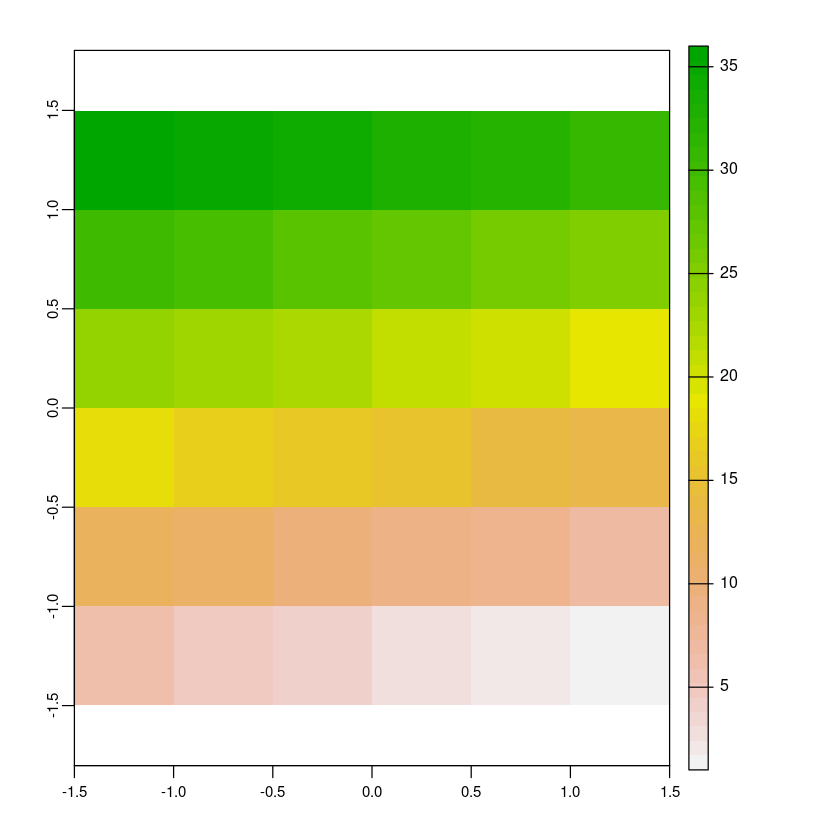

In [6]:
plot(elev)


In [7]:

grain_order = c("clay", "silt", "sand")
grain_char = sample(grain_order, 36, replace = TRUE)
grain_fact = factor(grain_char, levels = grain_order)
grain = rast(nrows = 6, ncols = 6, resolution = 0.5, 
             xmin = -1.5, xmax = 1.5, ymin = -1.5, ymax = 1.5,
             vals = grain_fact)


two_layers = c(grain, elev) 
names(two_layers) <- c("grain", "elev")


In [8]:

two_layers

class       : SpatRaster 
dimensions  : 6, 6, 2  (nrow, ncol, nlyr)
resolution  : 0.5, 0.5  (x, y)
extent      : -1.5, 1.5, -1.5, 1.5  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 
sources     : memory  
              memory  
names       : grain, elev 
min values  :  clay,    1 
max values  :  silt,   36 

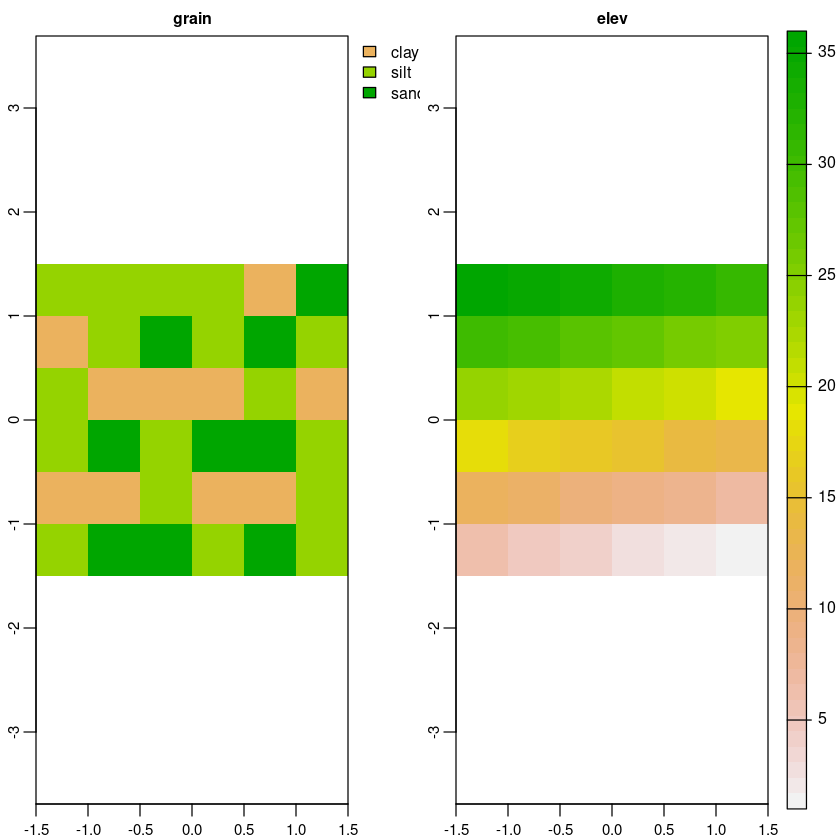

In [9]:
two_layers %>%
    plot()

## Retrieving values from a raster object



<img src="img/pixel.svg" alt="drawing" width="400"/>


If we know the pixel index of an object, we can simply use `R`'s indexing mechanism

In [10]:
elev[4,3]

lyr.1
1 16

If we only know the coordinates within the CRS, we can use `terra`'s function `cellFromXY`.

In [11]:
(id = cellFromXY(elev, matrix(c(-0.2, -0.2), ncol=2)))



[1] 21

In [12]:
elev[id]

lyr.1
1 16

## Raster-vector cropping

(example from https://geocompr.robinlovelace.net/geometric-operations.html#geo-ras)

Two objects:
- A `SpatRaster` object `srtm` representing elevation (meters above sea level) in south-western Utah.
- A vector (`sf`) object zion representing Zion National Park.



In [13]:
install.packages("spDataLarge", repos = "https://geocompr.r-universe.dev")


Installing package into ‘/home/gjaeger/R/x86_64-pc-linux-gnu-library/4.0’
(as ‘lib’ is unspecified)



In [14]:
library(spDataLarge)

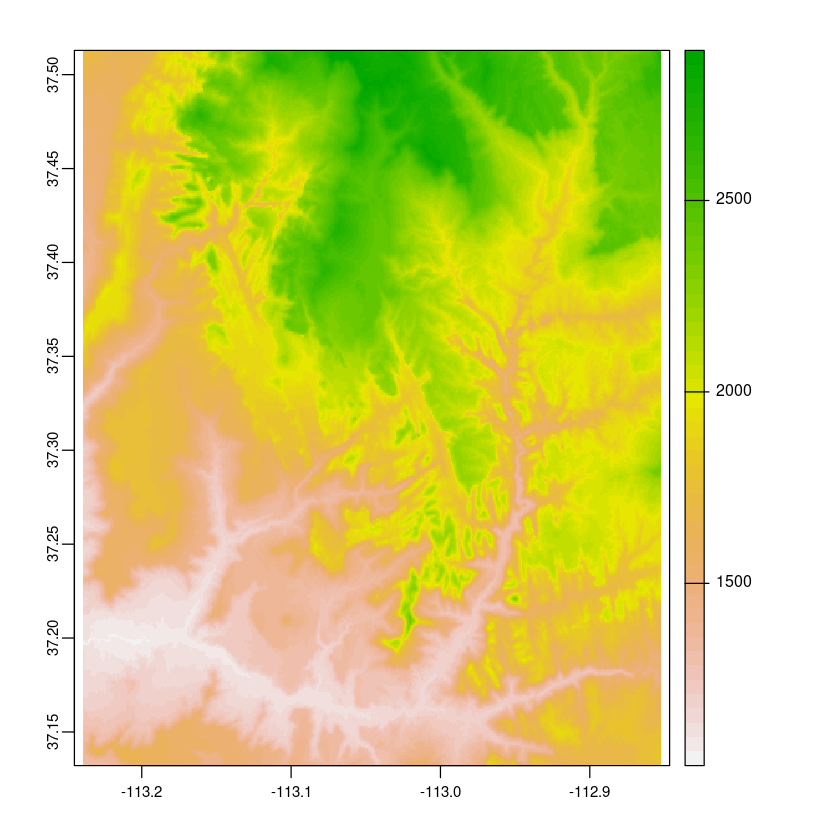

In [15]:
srtm = rast(system.file("raster/srtm.tif", package = "spDataLarge"))

plot(srtm)


Reading layer `zion' from data source 
  `/home/gjaeger/R/x86_64-pc-linux-gnu-library/4.0/spDataLarge/vector/zion.gpkg' 
  using driver `GPKG'
Simple feature collection with 1 feature and 11 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 302903.1 ymin: 4112244 xmax: 334735.5 ymax: 4153087
Projected CRS: UTM Zone 12, Northern Hemisphere


Warning message:
“plotting the first 9 out of 11 attributes; use max.plot = 11 to plot all”


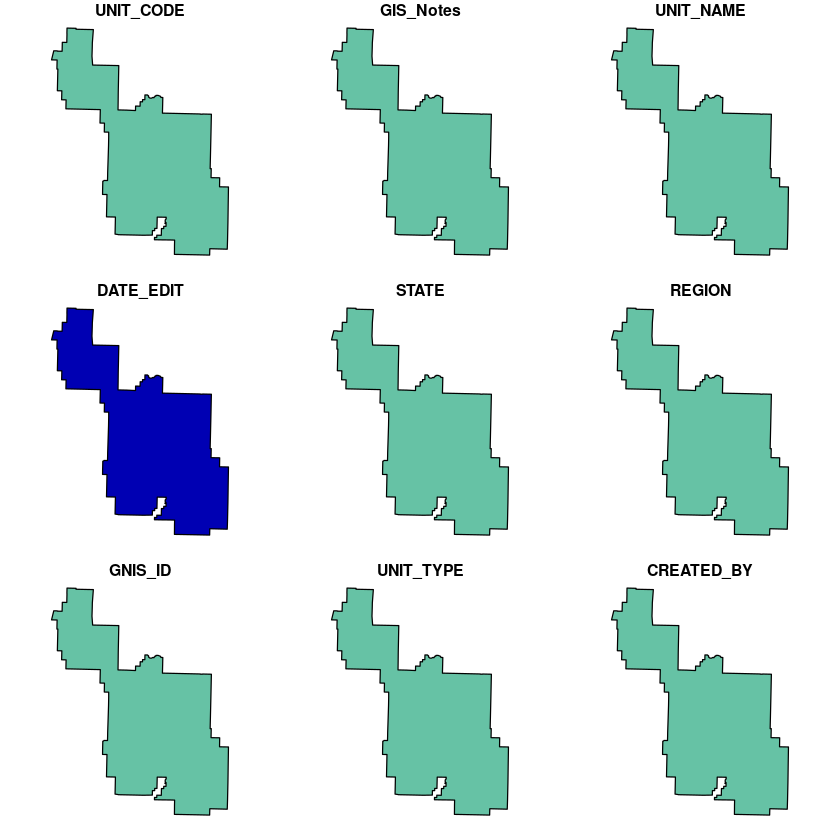

In [17]:
zion = st_read(system.file("vector/zion.gpkg", package = "spDataLarge"))
plot(zion)

We have to make sure that both objects have the same CRS/projection.

In [18]:
zion %>% crs()

Coordinate Reference System:
Deprecated Proj.4 representation:
 +proj=utm +zone=12 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m
+no_defs 
WKT2 2019 representation:
BOUNDCRS[
    SOURCECRS[
        PROJCRS["UTM Zone 12, Northern Hemisphere",
            BASEGEOGCRS["GRS 1980(IUGG, 1980)",
                DATUM["unknown",
                    ELLIPSOID["GRS80",6378137,298.257222101,
                        LENGTHUNIT["metre",1,
                            ID["EPSG",9001]]]],
                PRIMEM["Greenwich",0,
                    ANGLEUNIT["degree",0.0174532925199433]]],
            CONVERSION["UTM zone 12N",
                METHOD["Transverse Mercator",
                    ID["EPSG",9807]],
                PARAMETER["Latitude of natural origin",0,
                    ANGLEUNIT["degree",0.0174532925199433],
                    ID["EPSG",8801]],
                PARAMETER["Longitude of natural origin",-111,
                    ANGLEUNIT["degree",0.0174532925199433],
                    ID

In [19]:
zion = st_transform(zion, crs(srtm))

zion %>% crs()

Coordinate Reference System:
Deprecated Proj.4 representation: +proj=longlat +datum=WGS84 +no_defs 
WKT2 2019 representation:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]] 

**Cropping** reduces the size of the raster object to the smallest rectangle fully including the vector object.

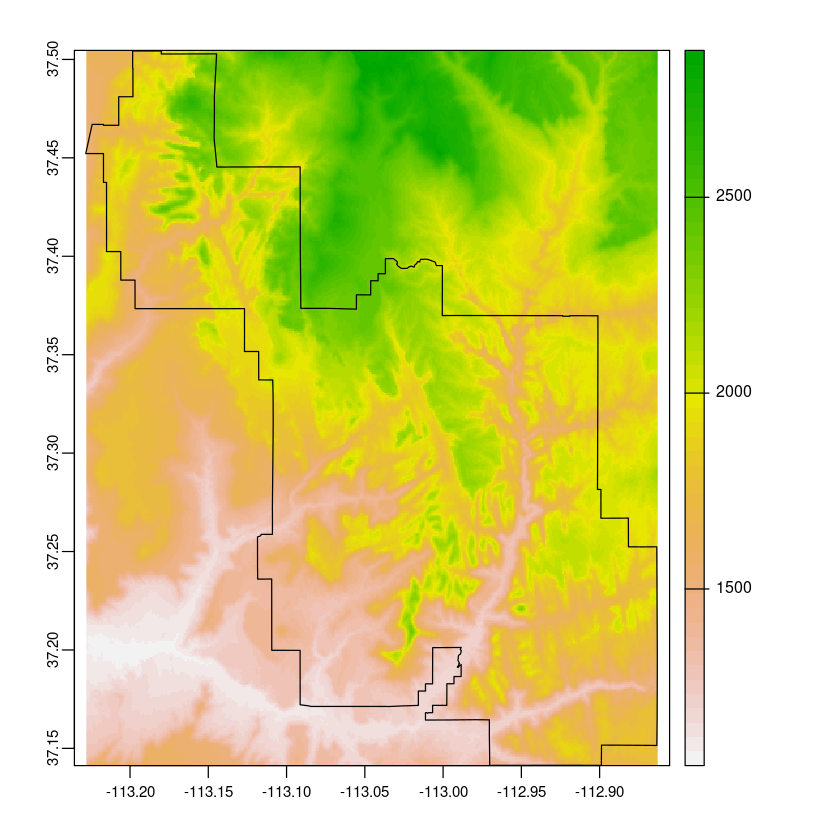

In [20]:
srtm_cropped = crop(srtm, vect(zion))

plot(srtm_cropped)
plot(vect(zion), add=T)

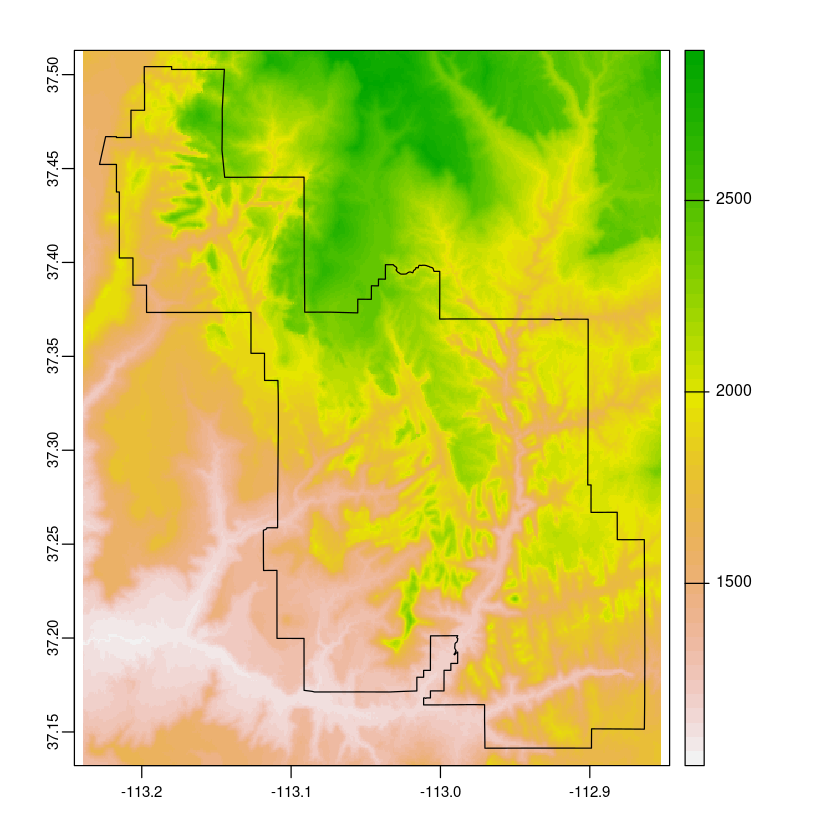

In [21]:
plot(srtm)
plot(vect(zion), add=T)

**Masking** sets all values of the raster object outside the boundaries of the vector object to `NA`.


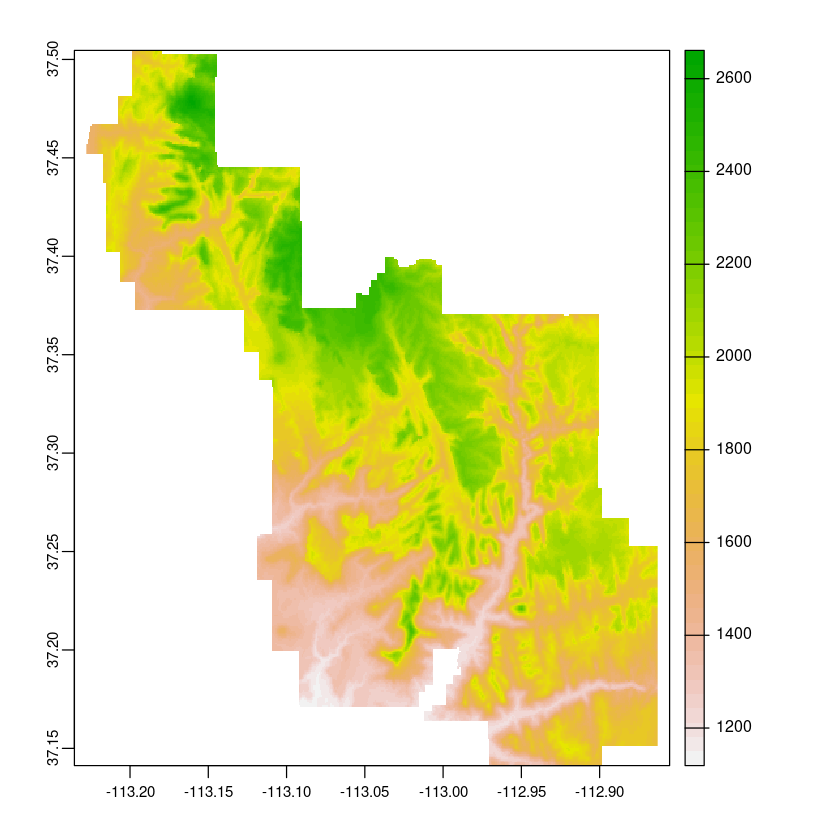

In [22]:
srtm_final = mask(srtm_cropped, vect(zion))
plot(srtm_final)

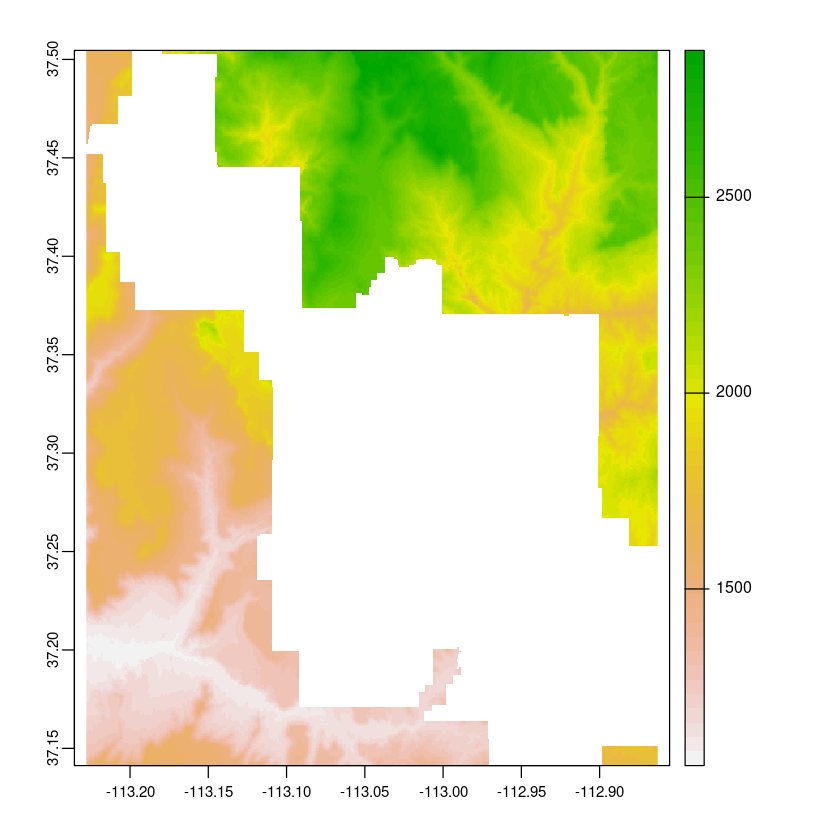

In [23]:
srtm_cropped %>%
    mask(vect(zion), inverse=T) %>%
    plot()

## Raster data file I/O

As for vector data, there is a multitude of file formats for raster data.

The function `rast` from `terra` works with the most common formats.

In [24]:
raster_filepath = system.file("raster/srtm.tif", package = "spDataLarge")
single_layer = rast(raster_filepath)

In [25]:
single_layer

class       : SpatRaster 
dimensions  : 457, 465, 1  (nrow, ncol, nlyr)
resolution  : 0.0008333333, 0.0008333333  (x, y)
extent      : -113.2396, -112.8521, 37.13208, 37.51292  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 (EPSG:4326) 
source      : srtm.tif 
name        : srtm 
min value   : 1024 
max value   : 2892 

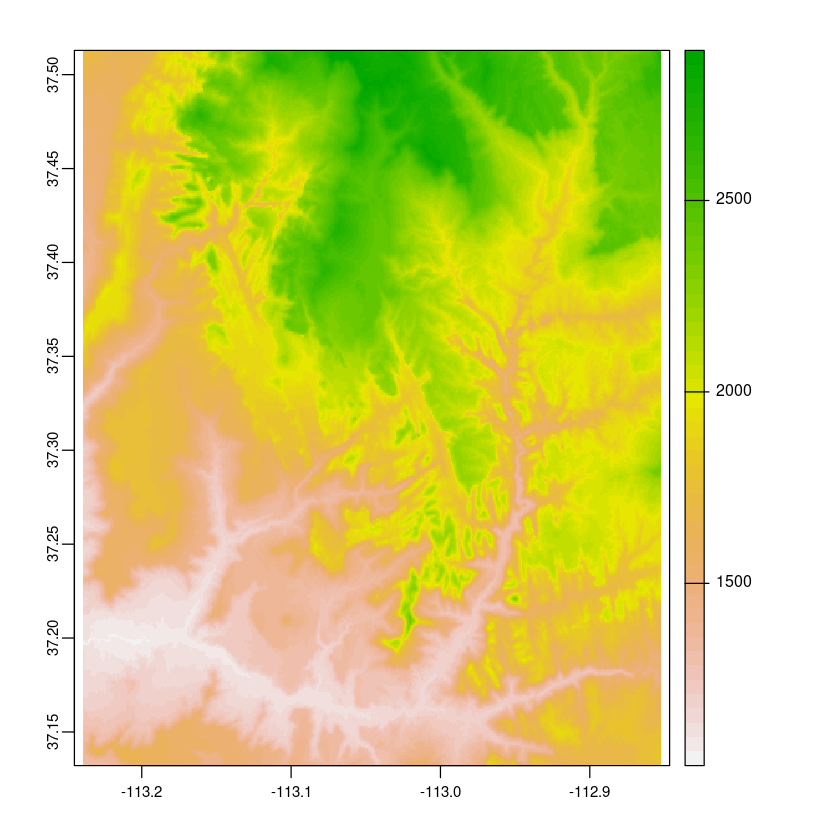

In [26]:
single_layer %>%
    plot()

In [27]:
multilayer_filepath = system.file("raster/landsat.tif", package = "spDataLarge")
multilayer_rast = rast(multilayer_filepath)

multilayer_rast

class       : SpatRaster 
dimensions  : 1428, 1128, 4  (nrow, ncol, nlyr)
resolution  : 30, 30  (x, y)
extent      : 301905, 335745, 4111245, 4154085  (xmin, xmax, ymin, ymax)
coord. ref. : WGS 84 / UTM zone 12N (EPSG:32612) 
source      : landsat.tif 
names       : lan_1, lan_2, lan_3, lan_4 
min values  :  7550,  6404,  5678,  5252 
max values  : 19071, 22051, 25780, 31961 

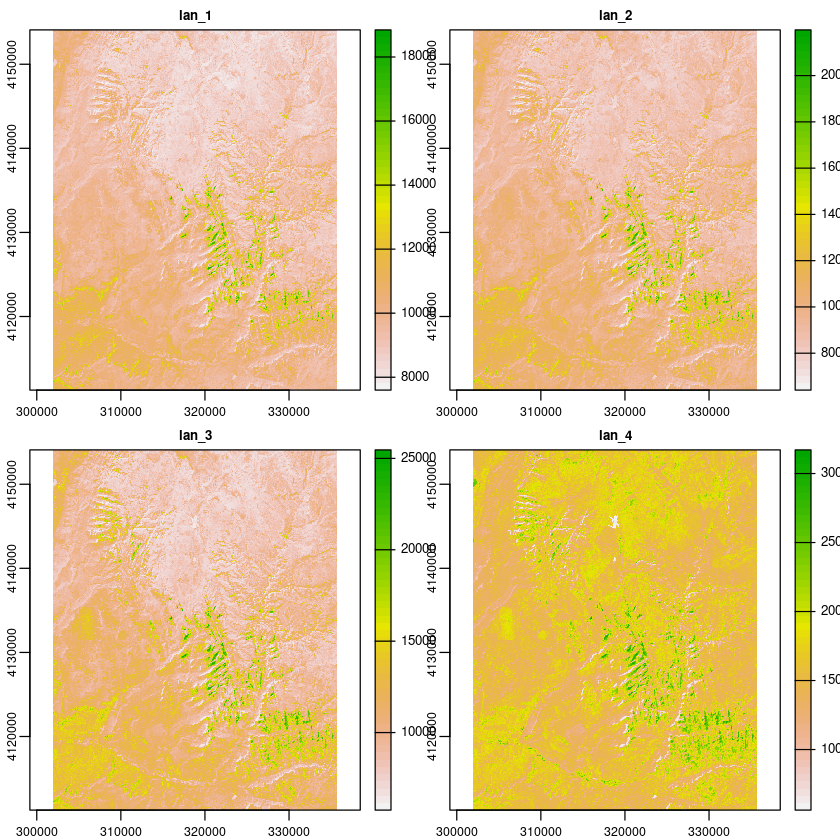

In [28]:
multilayer_rast %>%
    plot()

Raster data can be saved to disk with `writeRaster`; the filename extension - if recognized - determines the output format. 

# Map maping in R

In [29]:
library(sf)
library(raster)
library(dplyr)
library(spData)
library(spDataLarge)

Loading required package: sp


Attaching package: ‘raster’


The following object is masked from ‘package:dplyr’:

    select




In [30]:
library(tmap)    # for static and interactive maps
library(leaflet) # for interactive maps
library(gifski)

Registered S3 methods overwritten by 'stars':
  method             from
  st_bbox.SpatRaster sf  
  st_crs.SpatRaster  sf  



In [31]:
nz_elev

class      : RasterLayer 
dimensions : 1450, 1115, 1616750  (nrow, ncol, ncell)
resolution : 1000, 1000  (x, y)
extent     : 995456.5, 2110457, 4741961, 6191961  (xmin, xmax, ymin, ymax)
crs        : +proj=tmerc +lat_0=0 +lon_0=173 +k=0.9996 +x_0=1600000 +y_0=10000000 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs 
source     : memory
names      : elevation 
values     : 0, 4140.333  (min, max)


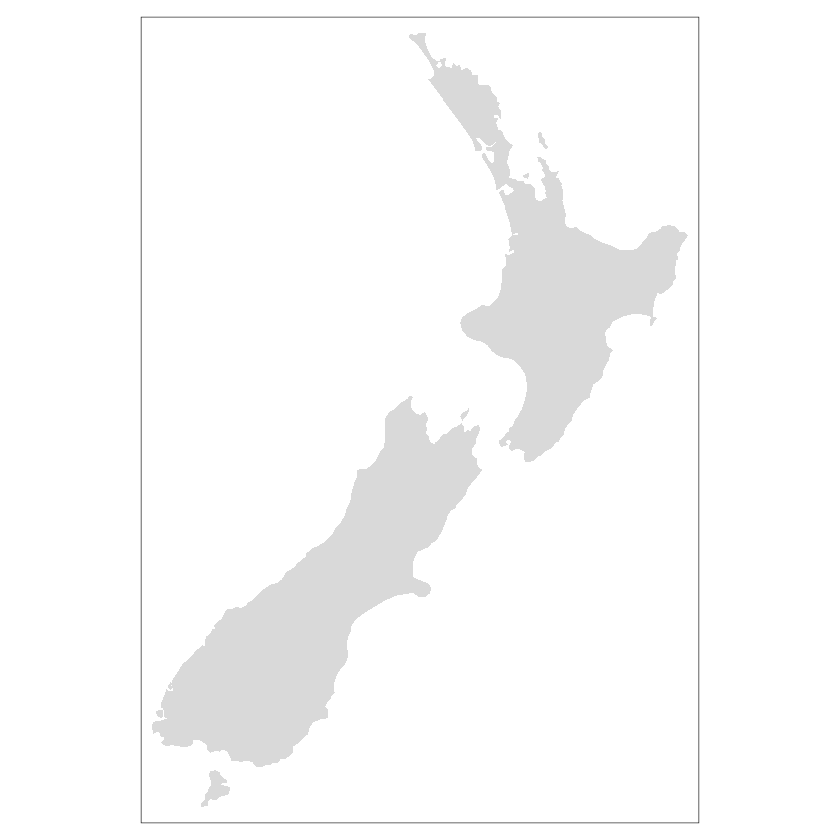

In [32]:
# Add fill layer to nz shape
tm_shape(nz) +
  tm_fill() 


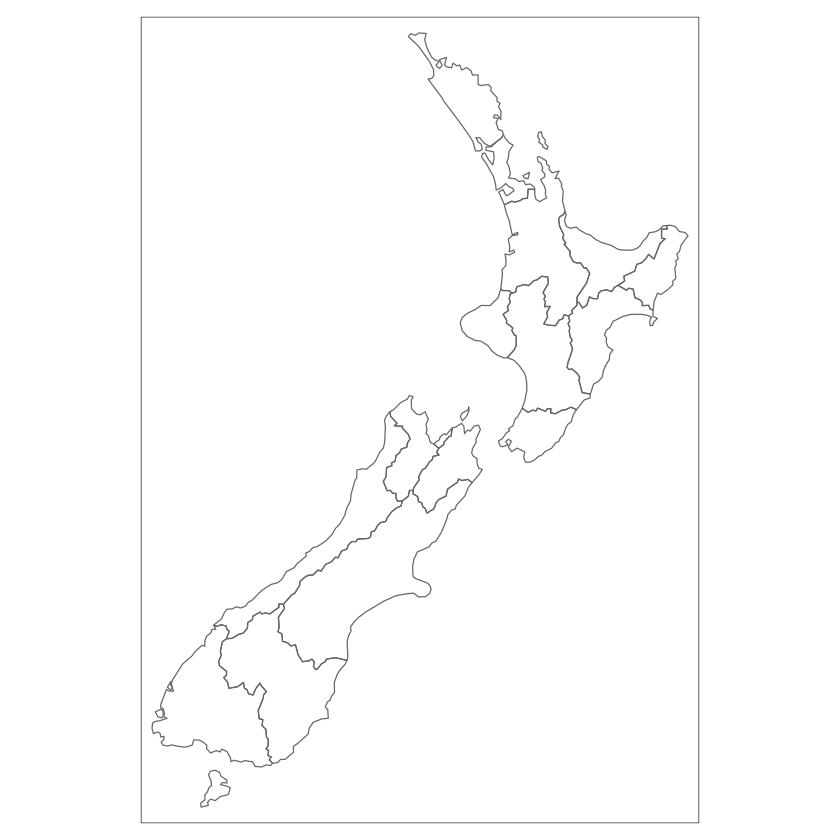

In [33]:
# Add border layer to nz shape
tm_shape(nz) +
  tm_borders() 


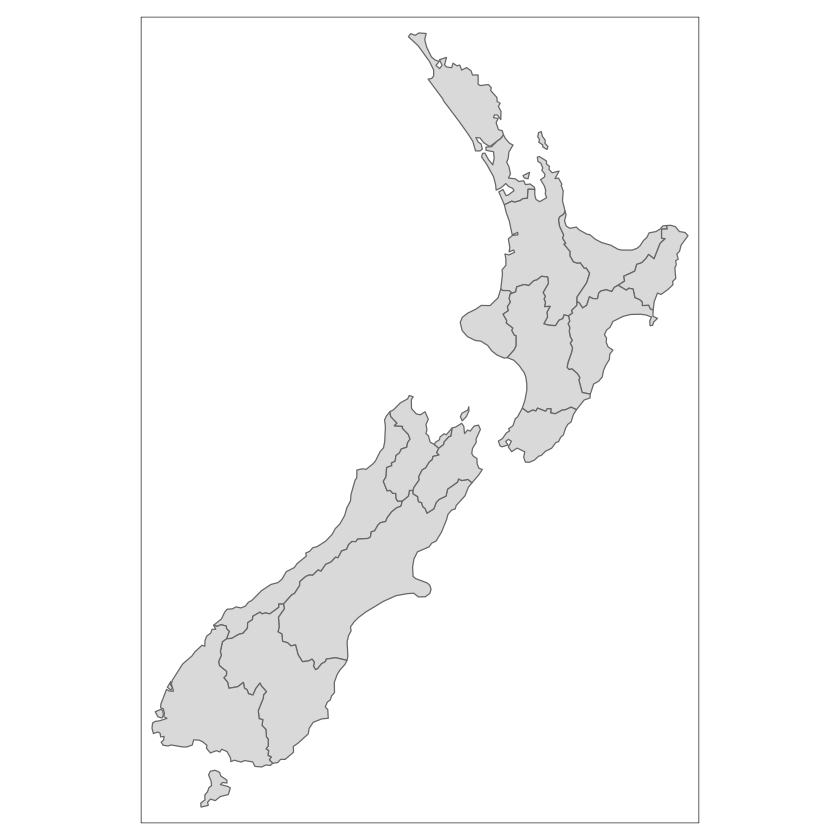

In [34]:
# Add fill and border layers to nz shape
tm_shape(nz) +
  tm_fill() +
  tm_borders() 

In [35]:
map_nz = tm_shape(nz) + tm_polygons()
class(map_nz)
#> [1] "tmap"

[1] "tmap"

In [36]:
nz_elev

class      : RasterLayer 
dimensions : 1450, 1115, 1616750  (nrow, ncol, ncell)
resolution : 1000, 1000  (x, y)
extent     : 995456.5, 2110457, 4741961, 6191961  (xmin, xmax, ymin, ymax)
crs        : +proj=tmerc +lat_0=0 +lon_0=173 +k=0.9996 +x_0=1600000 +y_0=10000000 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs 
source     : memory
names      : elevation 
values     : 0, 4140.333  (min, max)


stars object downsampled to 877 by 1140 cells. See tm_shape manual (argument raster.downsample)



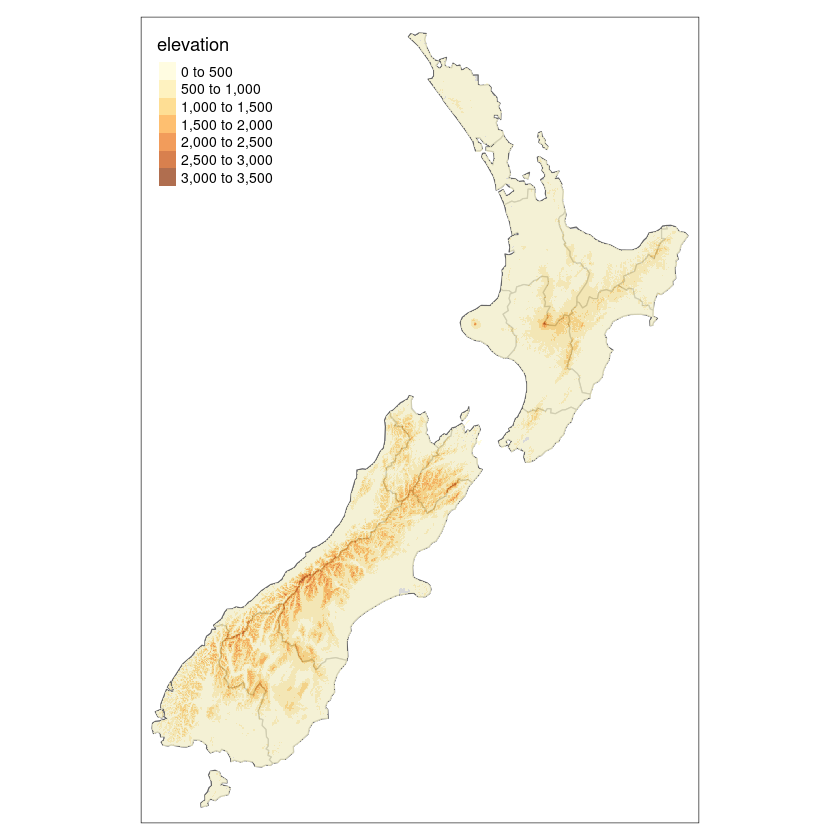

In [37]:
map_nz1 = map_nz +
  tm_shape(nz_elev) + tm_raster(alpha = 0.7)
map_nz1

In [38]:
nz_water = st_union(nz) %>% st_buffer(22200) %>% 
  st_cast(to = "LINESTRING")
nz_water

LINESTRING (1074909 4920220, 1074855 4920397, 1...

Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



Geometry set for 1 feature 
Geometry type: LINESTRING
Dimension:     XY
Bounding box:  xmin: 1067944 ymin: 4726340 xmax: 2111732 ymax: 6214066
Projected CRS: NZGD2000 / New Zealand Transverse Mercator 2000

stars object downsampled to 877 by 1140 cells. See tm_shape manual (argument raster.downsample)



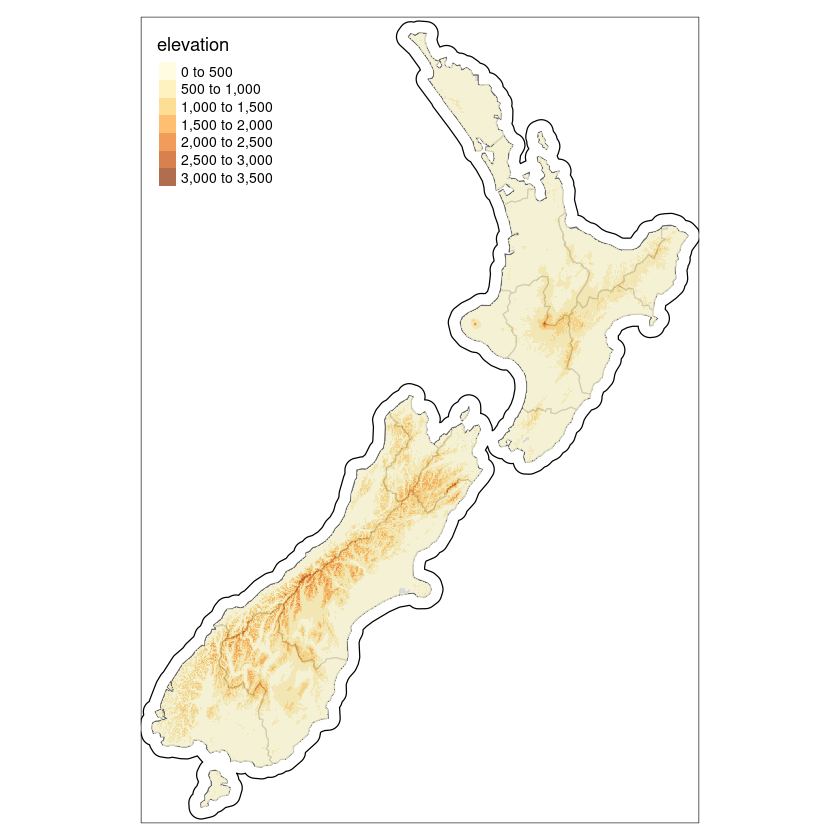

In [39]:
map_nz2 = map_nz1 +
  tm_shape(nz_water) + tm_lines()
map_nz2

stars object downsampled to 877 by 1140 cells. See tm_shape manual (argument raster.downsample)



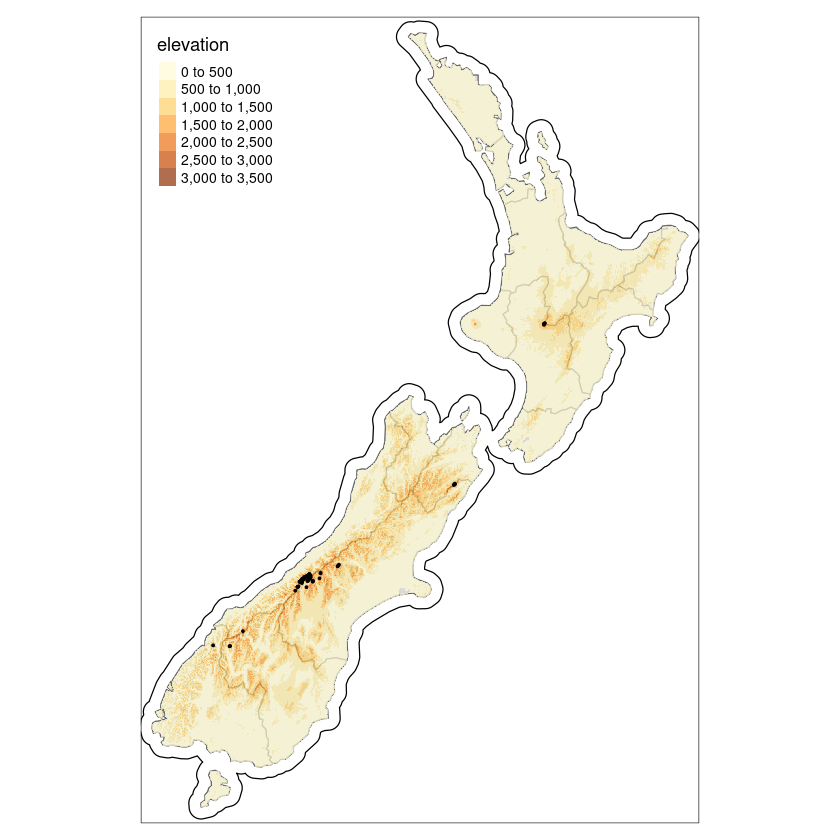

In [40]:
map_nz3 = map_nz2 +
  tm_shape(nz_height) + tm_dots()
map_nz3

stars object downsampled to 877 by 1140 cells. See tm_shape manual (argument raster.downsample)

stars object downsampled to 877 by 1140 cells. See tm_shape manual (argument raster.downsample)

stars object downsampled to 877 by 1140 cells. See tm_shape manual (argument raster.downsample)

stars object downsampled to 877 by 1140 cells. See tm_shape manual (argument raster.downsample)

stars object downsampled to 877 by 1140 cells. See tm_shape manual (argument raster.downsample)

stars object downsampled to 877 by 1140 cells. See tm_shape manual (argument raster.downsample)



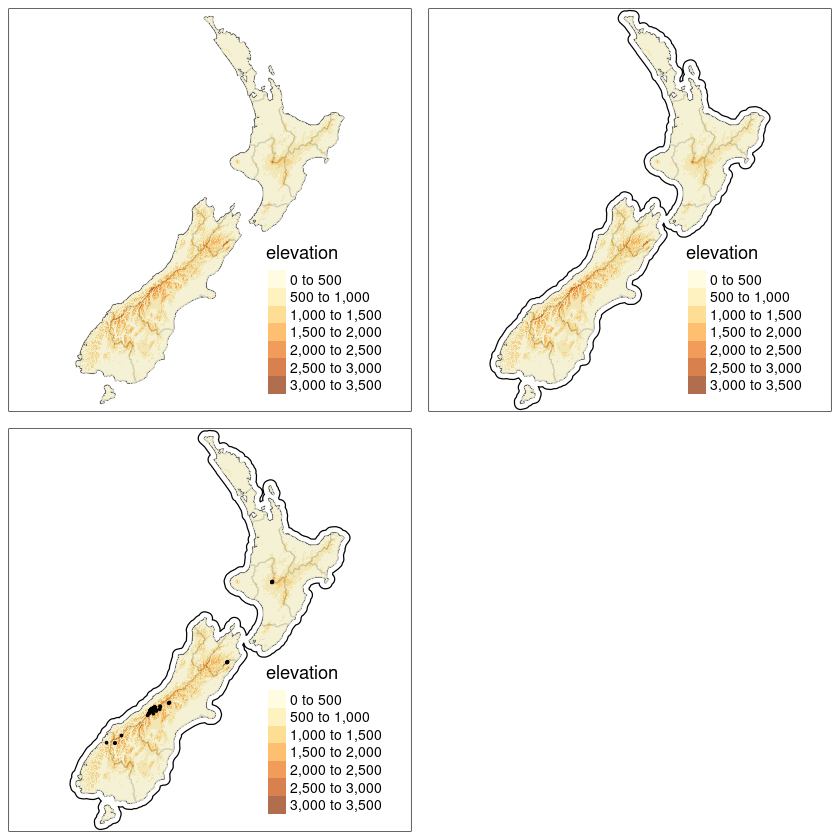

In [41]:
tmap_arrange(map_nz1, map_nz2, map_nz3)

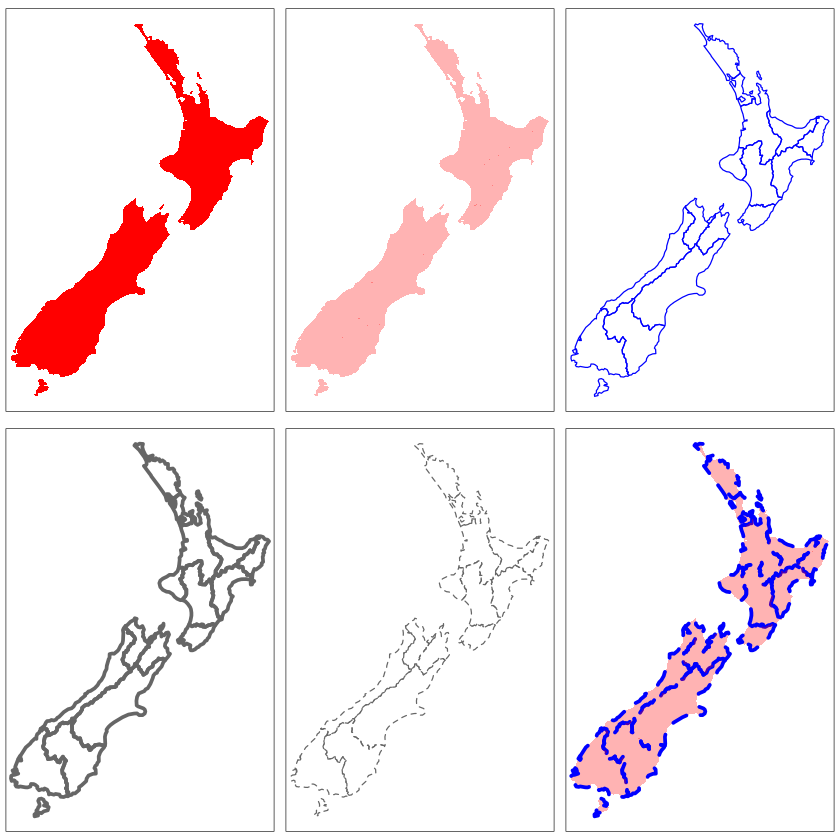

In [42]:
ma1 = tm_shape(nz) + tm_fill(col = "red")
ma2 = tm_shape(nz) + tm_fill(col = "red", alpha = 0.3)
ma3 = tm_shape(nz) + tm_borders(col = "blue")
ma4 = tm_shape(nz) + tm_borders(lwd = 3)
ma5 = tm_shape(nz) + tm_borders(lty = 2)
ma6 = tm_shape(nz) + tm_fill(col = "red", alpha = 0.3) +
  tm_borders(col = "blue", lwd = 3, lty = 2)
tmap_arrange(ma1, ma2, ma3, ma4, ma5, ma6)


In [43]:
nz %>% slice_head(n=10)

Name              Island Land_area Population Median_income Sex_ratio
1  Northland         North  12500.561  175500    23400         0.9424532
2  Auckland          North   4941.573 1657200    29600         0.9442858
3  Waikato           North  23900.036  460100    27900         0.9520500
4  Bay of Plenty     North  12071.145  299900    26200         0.9280391
5  Gisborne          North   8385.827   48500    24400         0.9349734
6  Hawke's Bay       North  14137.524  164000    26100         0.9238375
7  Taranaki          North   7254.480  118000    29100         0.9569363
8  Manawatu-Wanganui North  22220.608  234500    25000         0.9387734
9  Wellington        North   8048.553  513900    32700         0.9335524
10 West Coast        South  23245.456   32400    26900         1.0139072
   geom                          
1  MULTIPOLYGON (((1745493 600...
2  MULTIPOLYGON (((1803822 590...
3  MULTIPOLYGON (((1860345 585...
4  MULTIPOLYGON (((2049387 583...
5  MULTIPOLYGON (((2024489 567...
6  MULTIPOLYGON (((2024489 567...
7  MULTIPOLYGON (((1740438 571...
8  MULTIPOLYGON (((1866732 566...
9  MULTIPOLYGON (((1881590 548...
10 MULTIPOLYGON (((1557042 531...

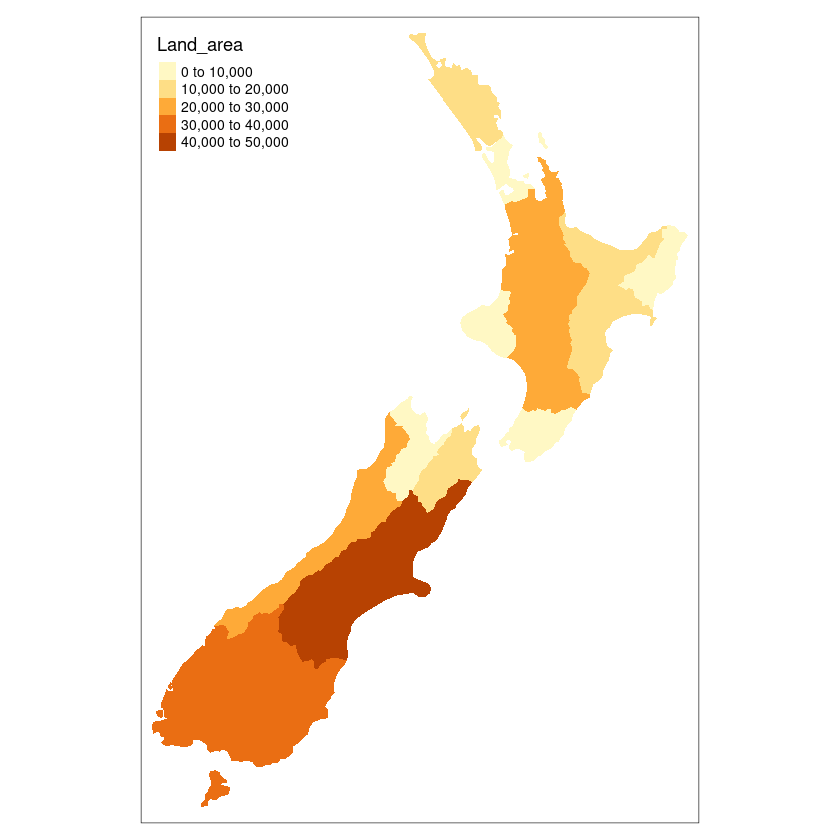

In [44]:
tm_shape(nz) + tm_fill(col = "Land_area")

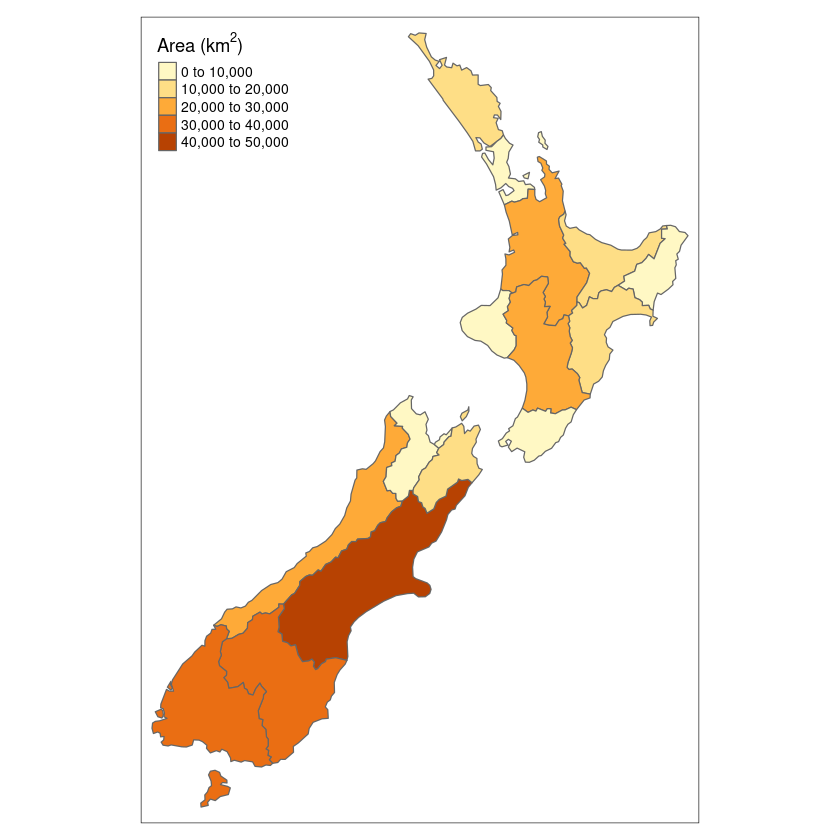

In [45]:
legend_title = expression("Area (km"^2*")")
map_nza = tm_shape(nz) +
  tm_fill(col = "Land_area", title = legend_title) + tm_borders()
map_nza

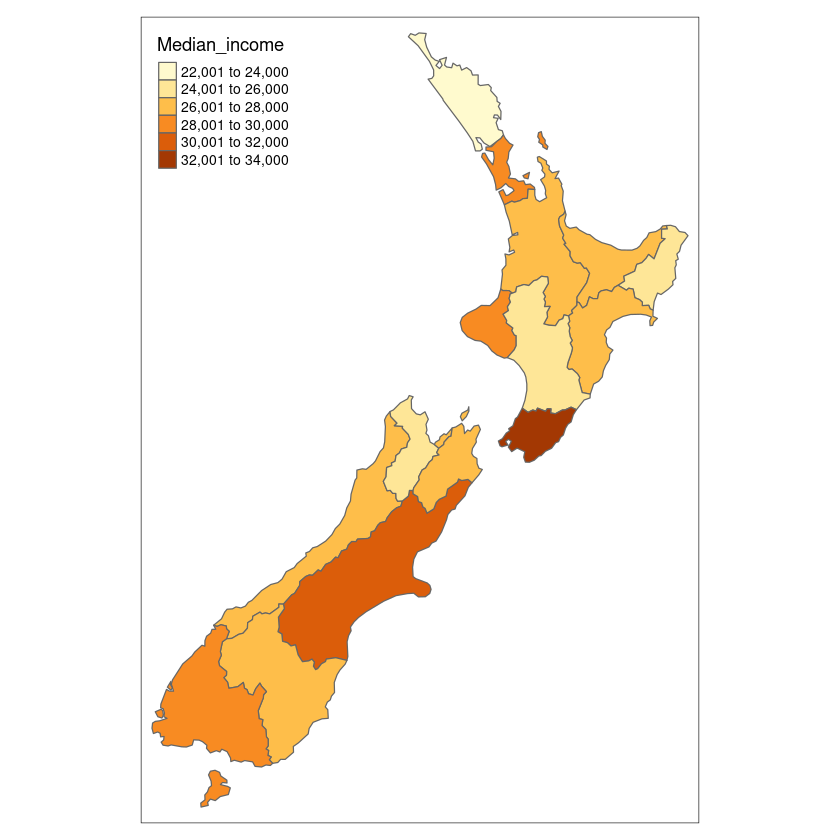

In [46]:
tm_shape(nz) + tm_polygons(col = "Median_income")
breaks = c(0, 3, 4, 5) * 10000


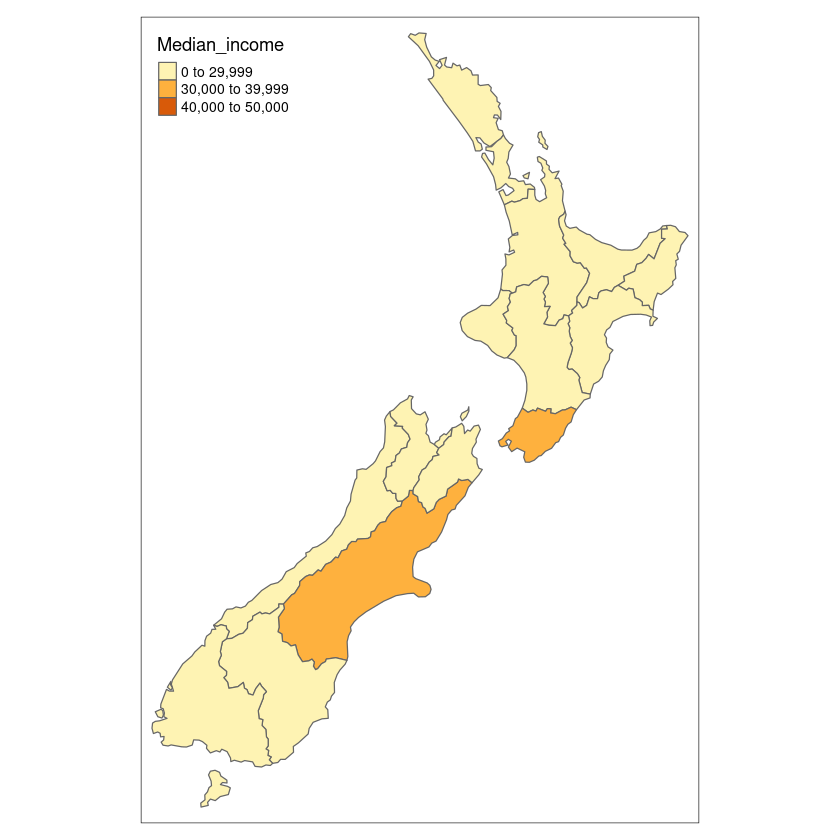

In [47]:
tm_shape(nz) + tm_polygons(col = "Median_income", breaks = breaks)


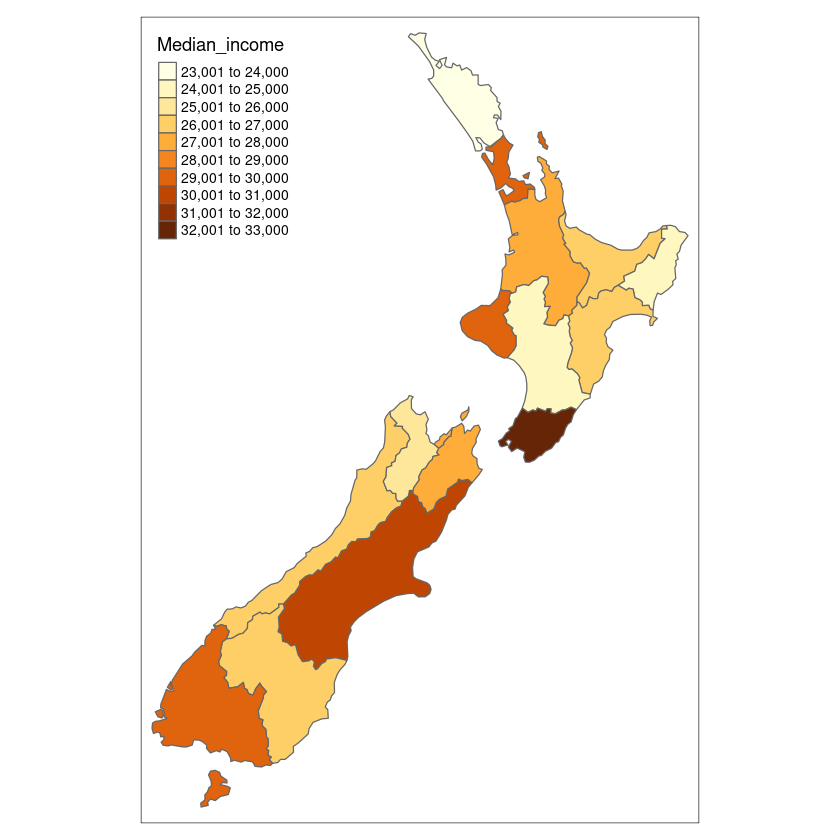

In [48]:
tm_shape(nz) + tm_polygons(col = "Median_income", n = 10)


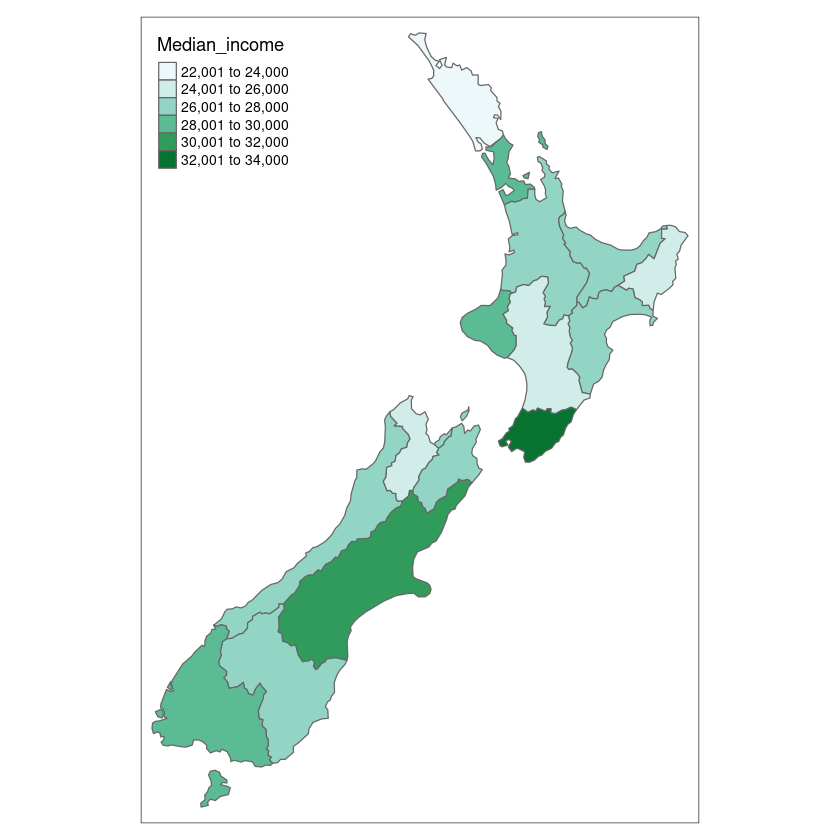

In [49]:
tm_shape(nz) + tm_polygons(col = "Median_income", palette = "BuGn")

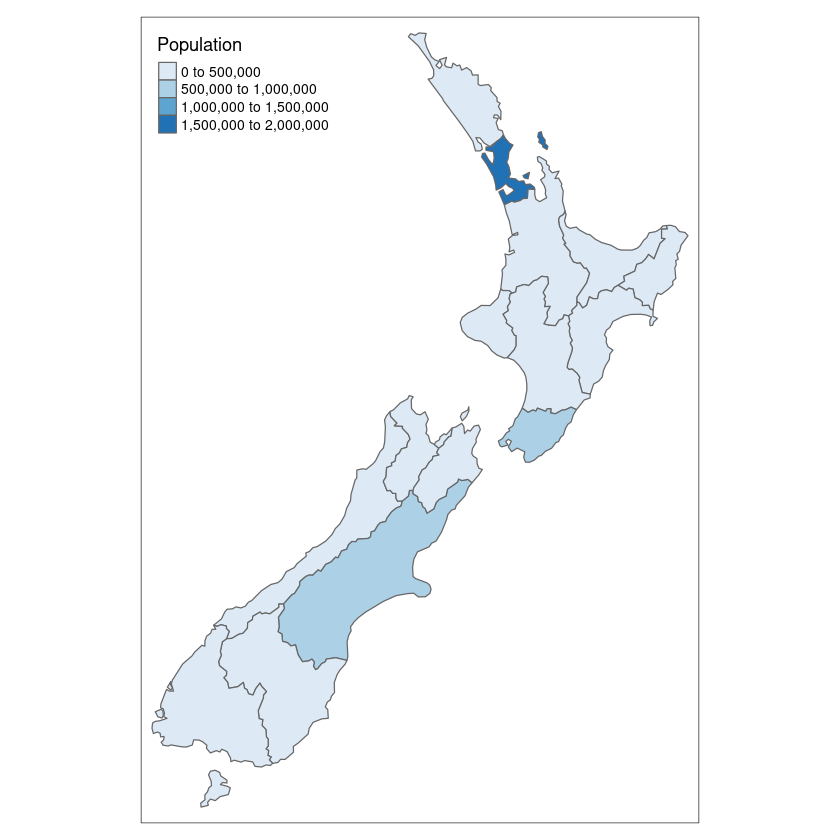

In [50]:
tm_shape(nz) + tm_polygons("Population", palette = "Blues")


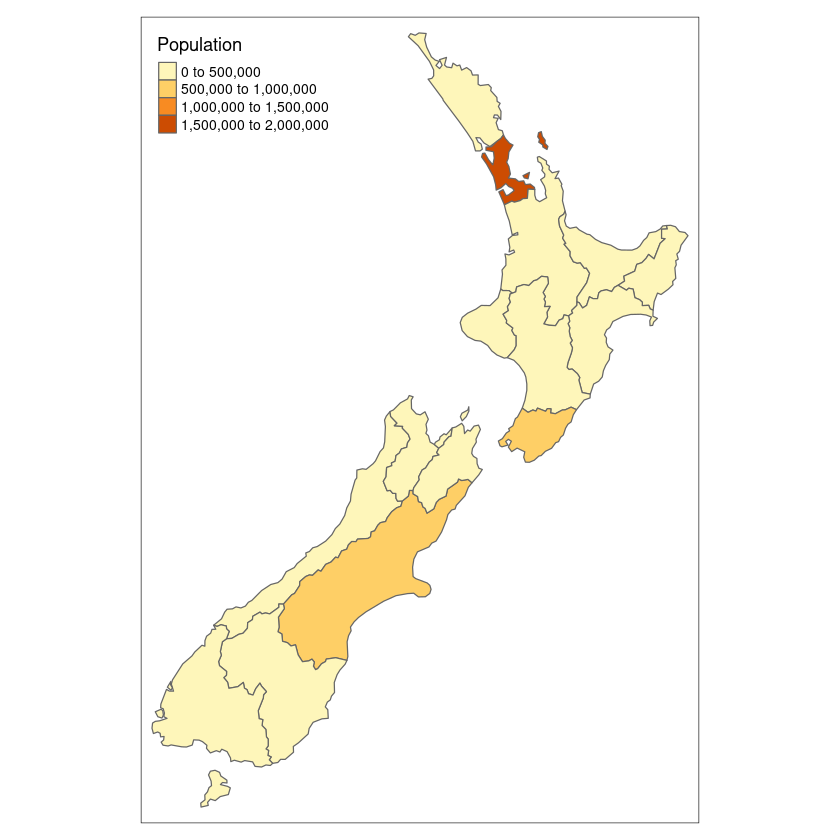

In [51]:
tm_shape(nz) + tm_polygons("Population", palette = "YlOrBr")

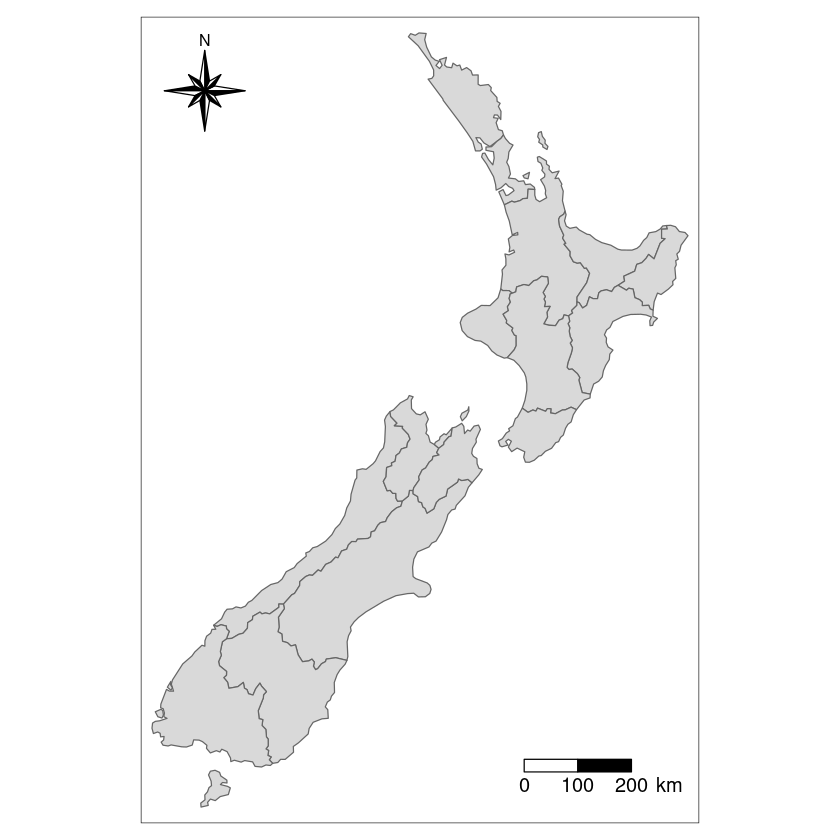

In [52]:
map_nz + 
  tm_compass(type = "8star", position = c("left", "top")) +
  tm_scale_bar(breaks = c(0, 100, 200), text.size = 1)

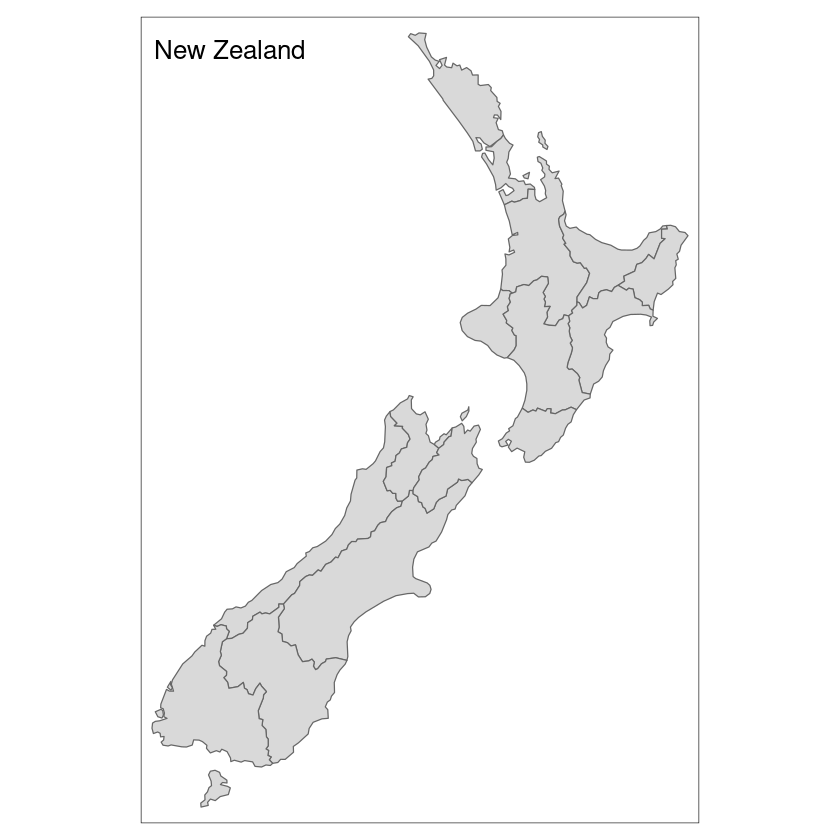

In [53]:
map_nz + tm_layout(title = "New Zealand")


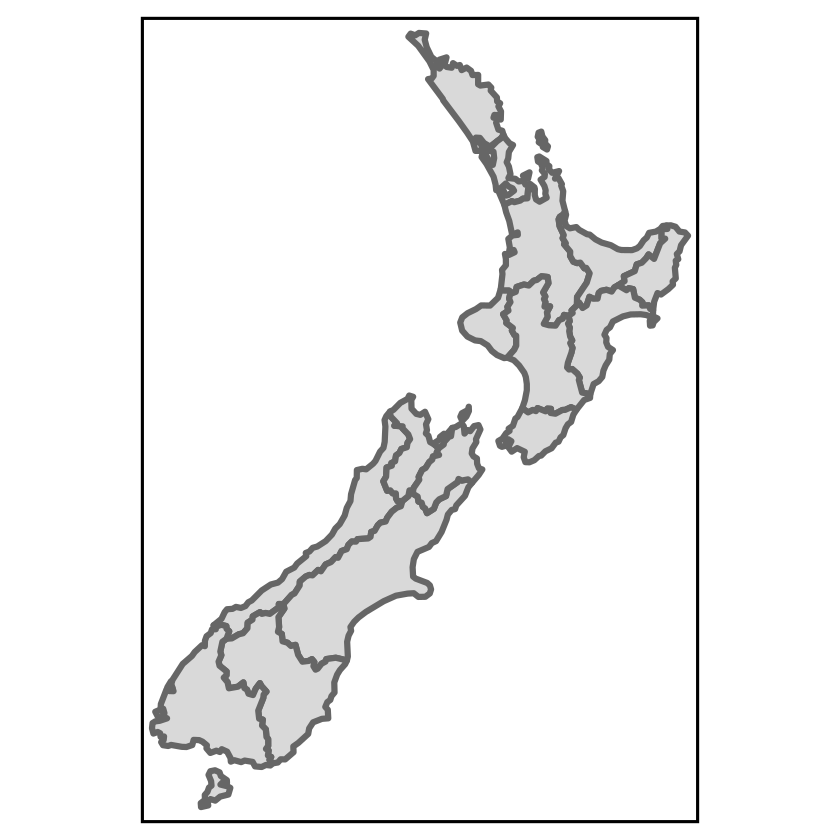

In [54]:
map_nz + tm_layout(scale = 5)


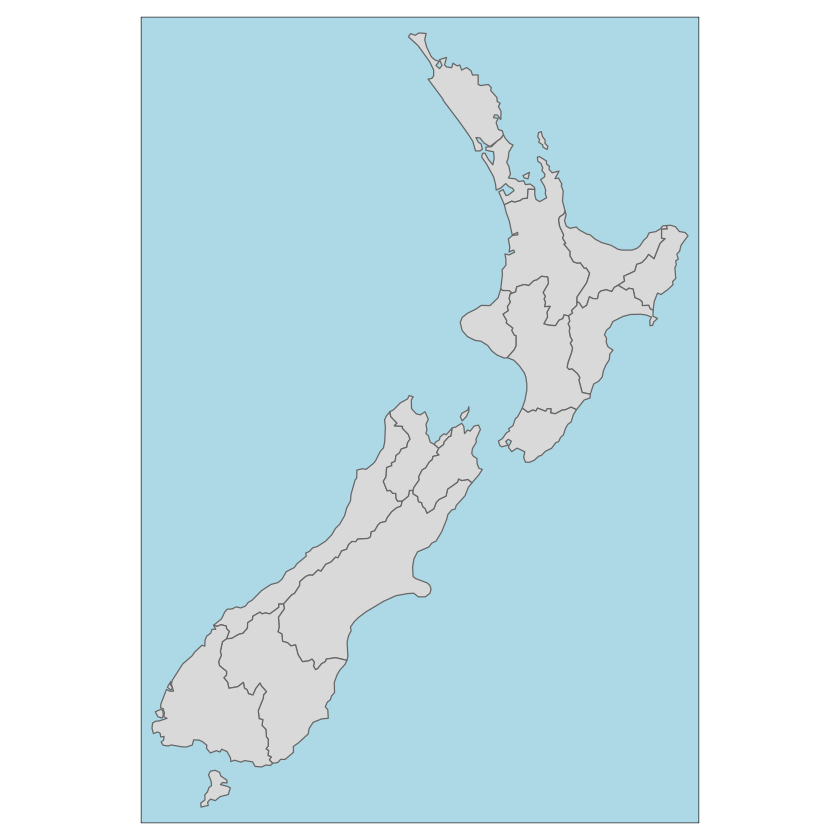

In [55]:
map_nz + tm_layout(bg.color = "lightblue")


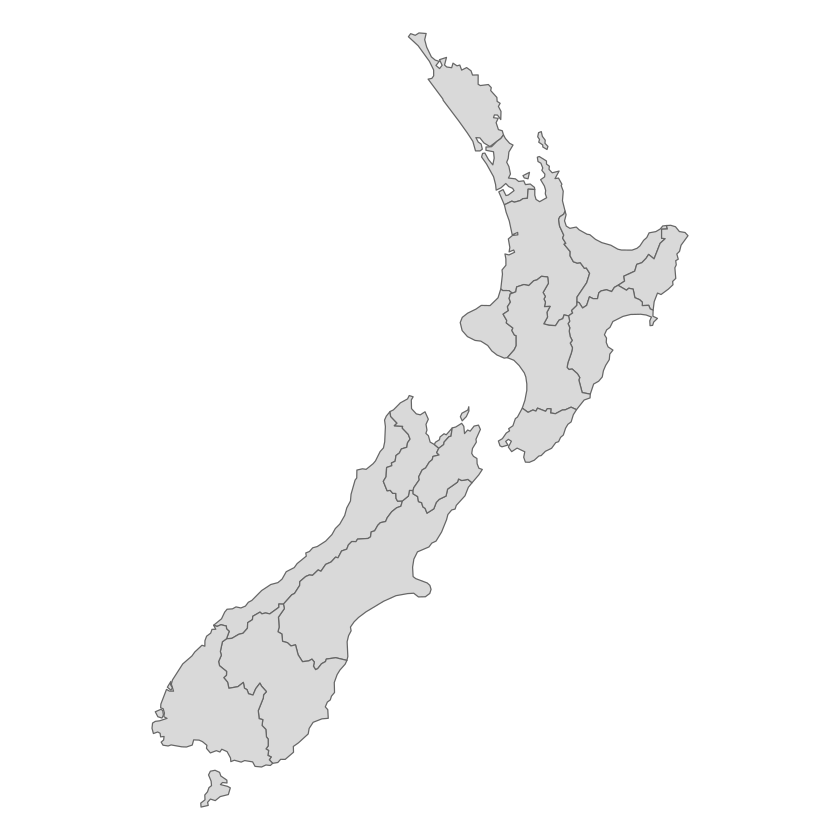

In [56]:
map_nz + tm_layout(frame = FALSE)

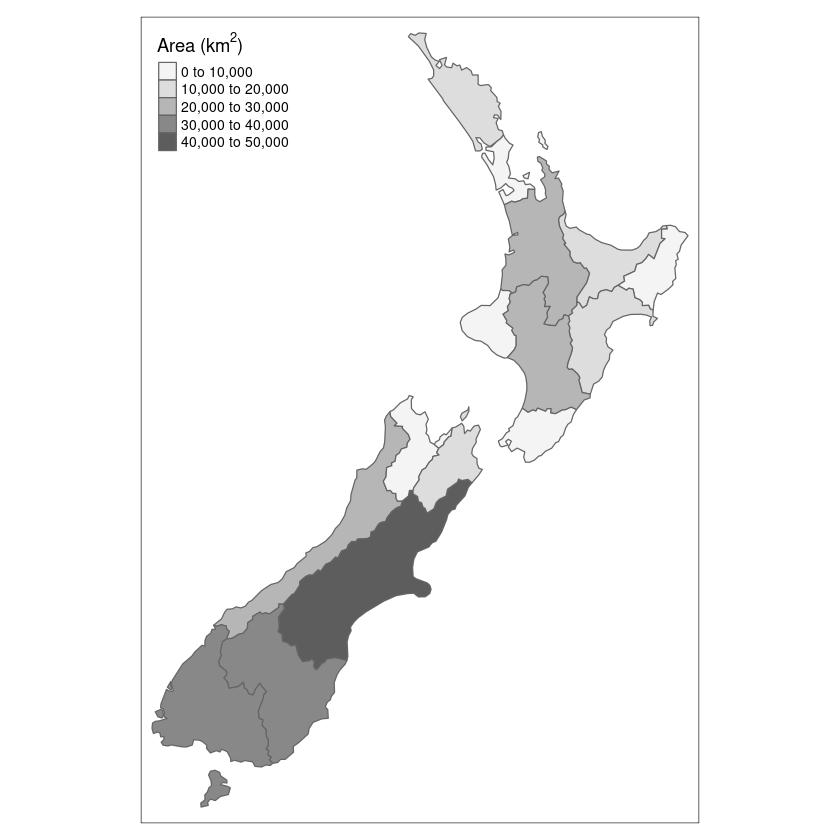

In [57]:
map_nza + tm_style("bw")


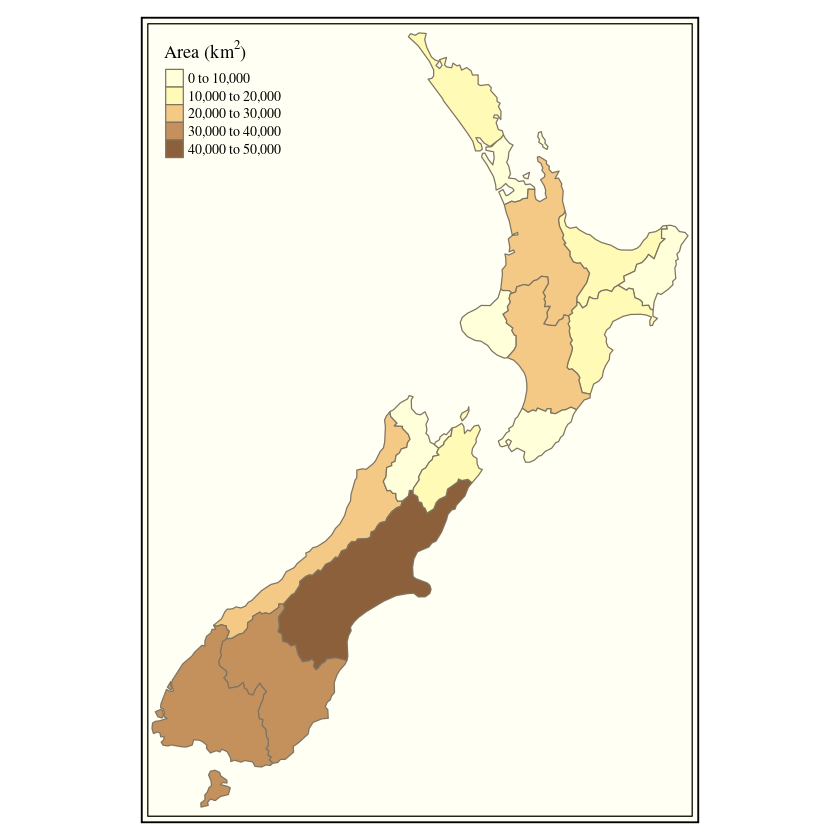

In [58]:
map_nza + tm_style("classic")


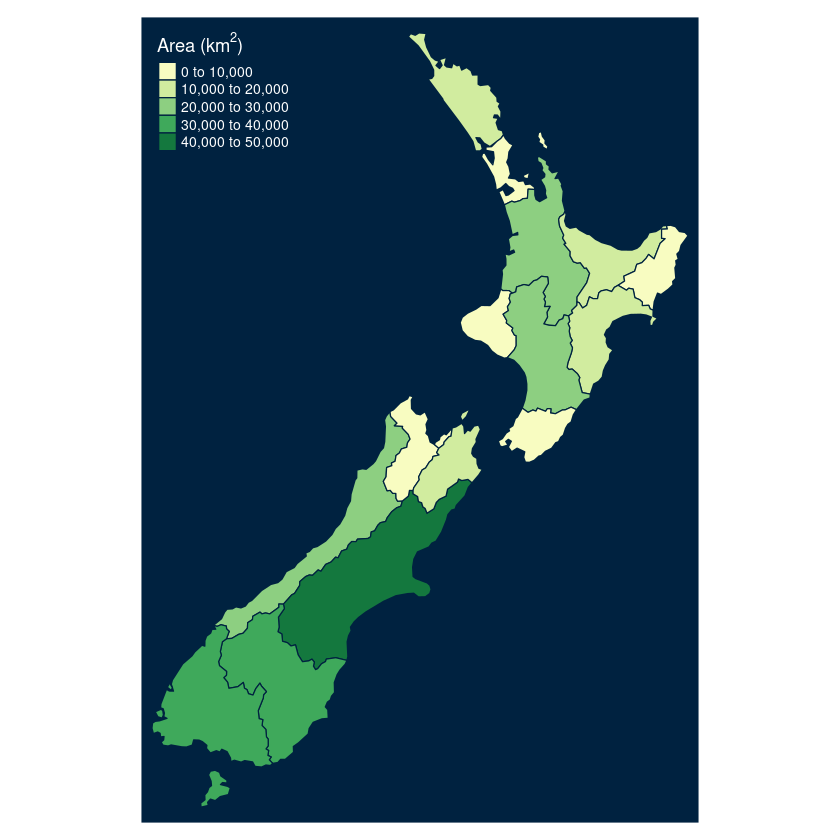

In [59]:
map_nza + tm_style("cobalt")


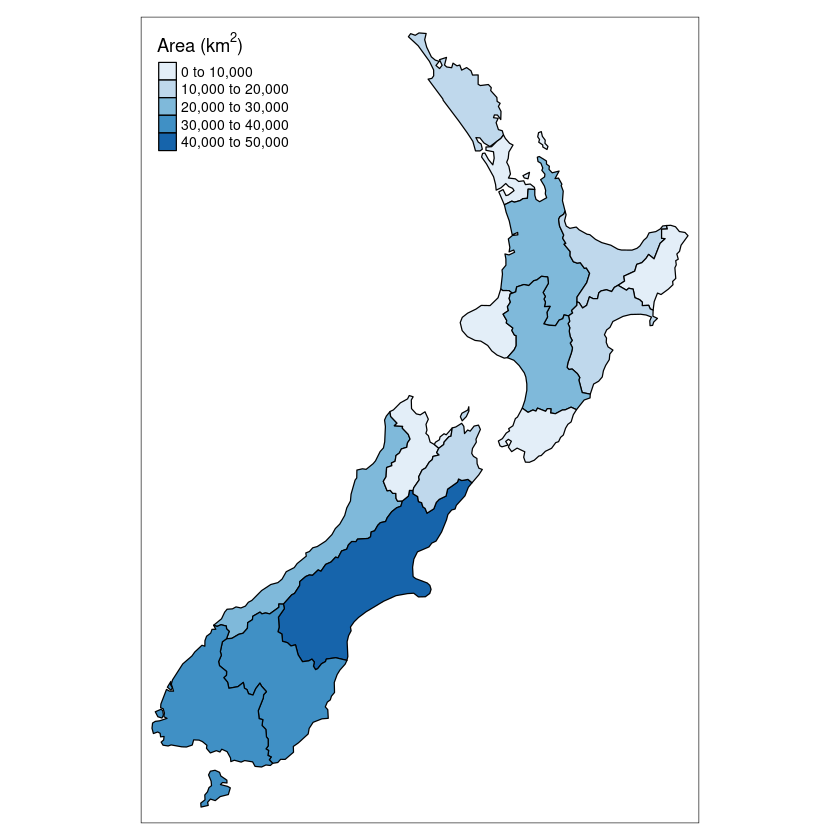

In [60]:
map_nza + tm_style("col_blind")

In [61]:
urb_1970_2030 = urban_agglomerations %>% 
  filter(year %in% c(1970, 1990, 2010, 2030))

urb_1970_2030 %>%
    slice_sample(n=10)

index year rank\norder country\ncode country_or_area                 
1  395   2030  8          484           Mexico                          
2  509   1970  6          840           United States of America        
3   31   2010 11           50           Bangladesh                      
4  413   2030 11          566           Nigeria                         
5  467   2030 19          608           Philippines                     
6  211   2010 27          180           Democratic Republic of the Congo
7  107   2030 14          156           China                           
8  161   2030 24          156           China                           
9  491   1970 21          792           Turkey                          
10 423   1990 18          586           Pakistan                        
   city_code urban_agglomeration              note population_millions
1  21853     Ciudad de México (Mexico City)   12   24.110599          
2  23052     Los Angeles-Long Beach-Santa Ana NA    8.377685          
3  20119     Dhaka                             2   14.730537          
4  22007     Lagos                            13   20.600156          
5  22109     Manila                           14   16.841340          
6  20853     Kinshasa                         NA    9.381673          
7  20484     Chongqing                         4   19.649097          
8  20667     Shenzhen                          5   14.537252          
9  22691     Istanbul                         NA    2.772095          
10 22044     Karachi                          NA    7.147064          
   geometry                  
1  POINT (-99.14187 19.42732)
2  POINT (-118.2417 34.03166)
3  POINT (90.40744 23.7104)  
4  POINT (3.39583 6.45306)   
5  POINT (120.9822 14.6042)  
6  POINT (15.31357 -4.32758) 
7  POINT (106.5528 29.56278) 
8  POINT (114.0634 22.54149) 
9  POINT (28.9497 41.0138)   
10 POINT (67.0822 24.9056)

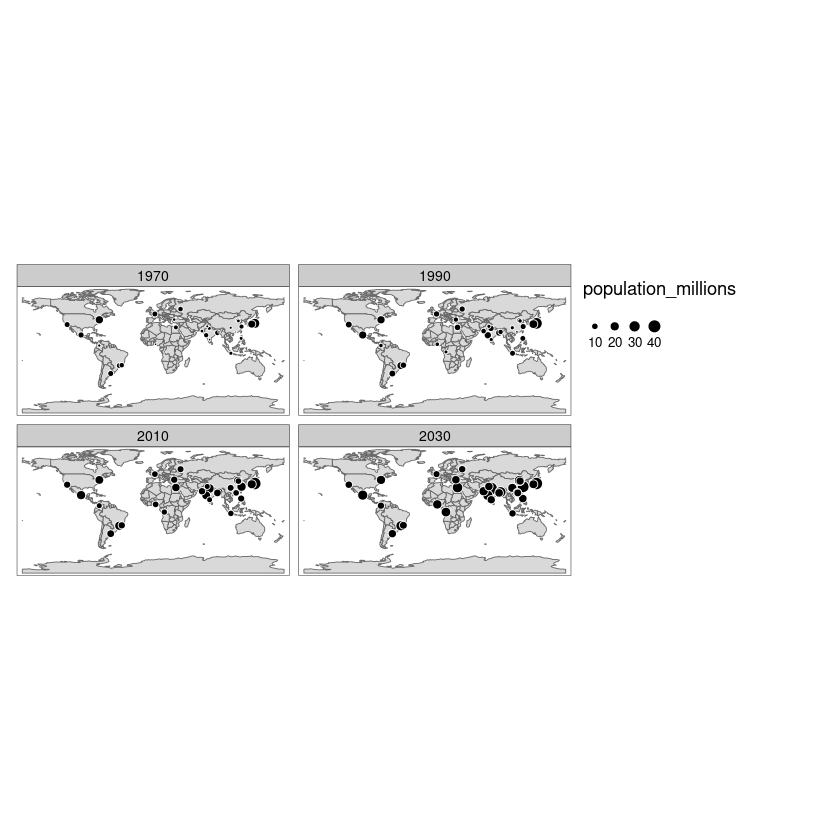

In [62]:

tm_shape(world) +
  tm_polygons() +
  tm_shape(urb_1970_2030) +
  tm_symbols(col = "black", border.col = "white", size = "population_millions") +
  tm_facets(by = "year", nrow = 2, free.coords = FALSE)

In [63]:
nz_region = st_bbox(c(xmin = 1340000, xmax = 1450000,
                      ymin = 5130000, ymax = 5210000),
                    crs = st_crs(nz_height)) %>% 
  st_as_sfc()
nz_region

POLYGON ((1340000 5130000, 1450000 5130000, 145...



Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1340000 ymin: 5130000 xmax: 1450000 ymax: 5210000
Projected CRS: NZGD2000 / New Zealand Transverse Mercator 2000

stars object downsampled to 877 by 1140 cells. See tm_shape manual (argument raster.downsample)



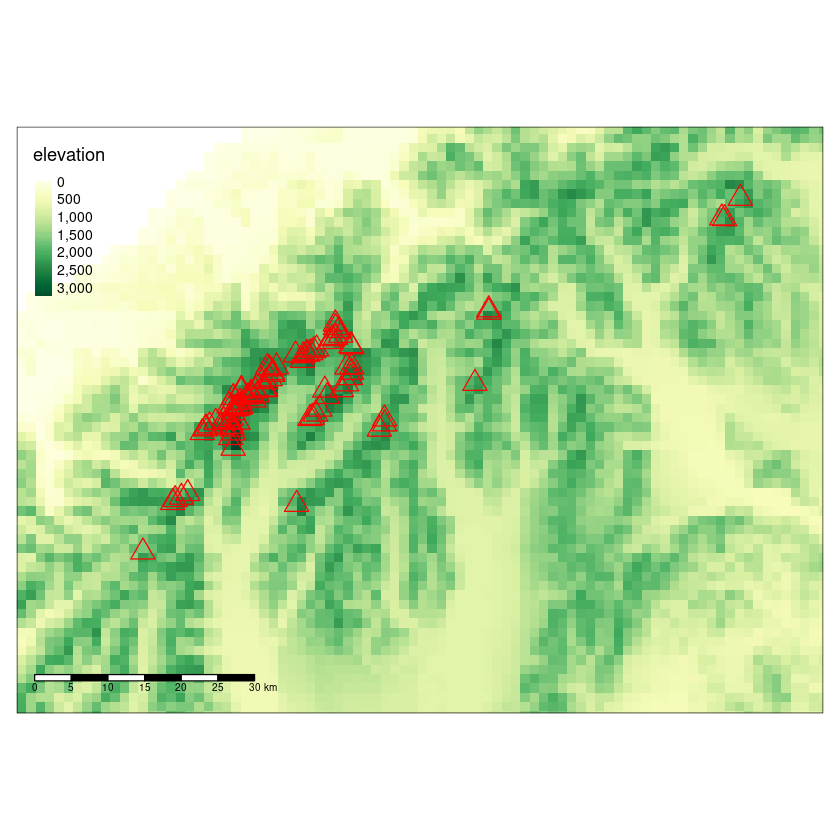

In [64]:
nz_height_map = tm_shape(nz_elev, bbox = nz_region) +
  tm_raster(style = "cont", palette = "YlGn", legend.show = TRUE) +
  tm_shape(nz_height) + tm_symbols(shape = 2, col = "red", size = 1) +
  tm_scale_bar(position = c("left", "bottom"))
nz_height_map

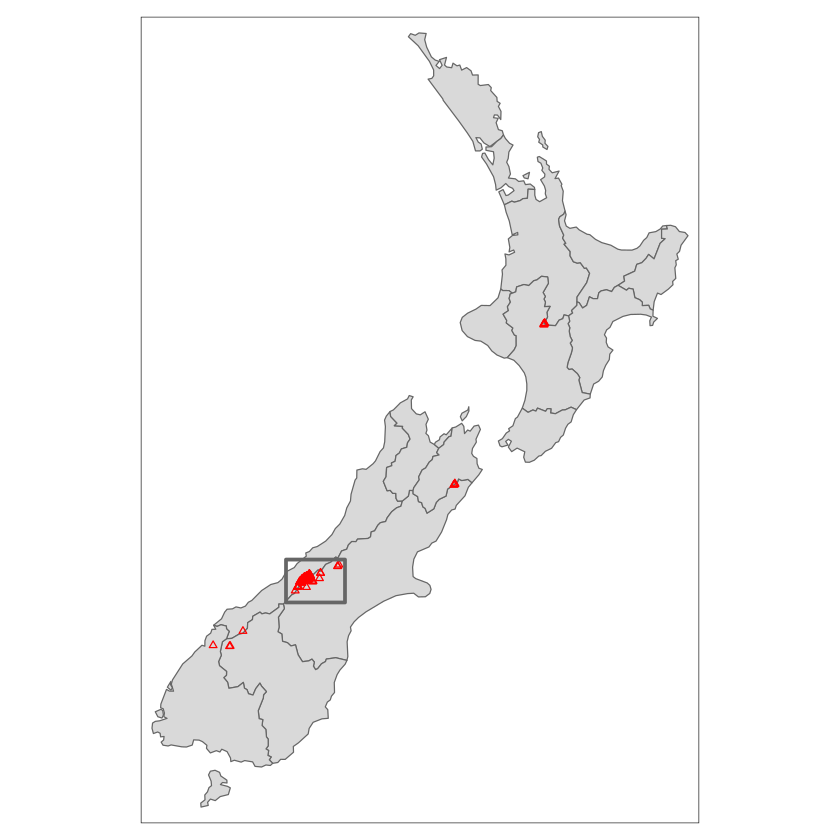

In [65]:
nz_map = tm_shape(nz) + tm_polygons() +
  tm_shape(nz_height) + tm_symbols(shape = 2, col = "red", size = 0.1) + 
  tm_shape(nz_region) + tm_borders(lwd = 3) 
nz_map

stars object downsampled to 877 by 1140 cells. See tm_shape manual (argument raster.downsample)



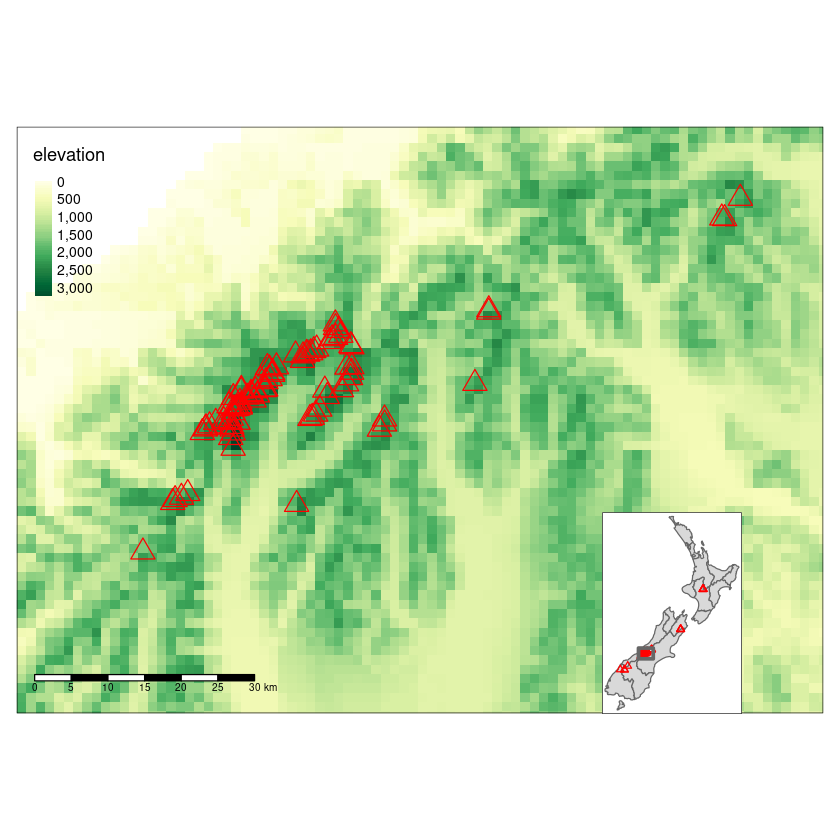

In [67]:
library(grid)
nz_height_map
print(nz_map, vp = viewport(0.8, 0.27, width = 0.5, height = 0.25))

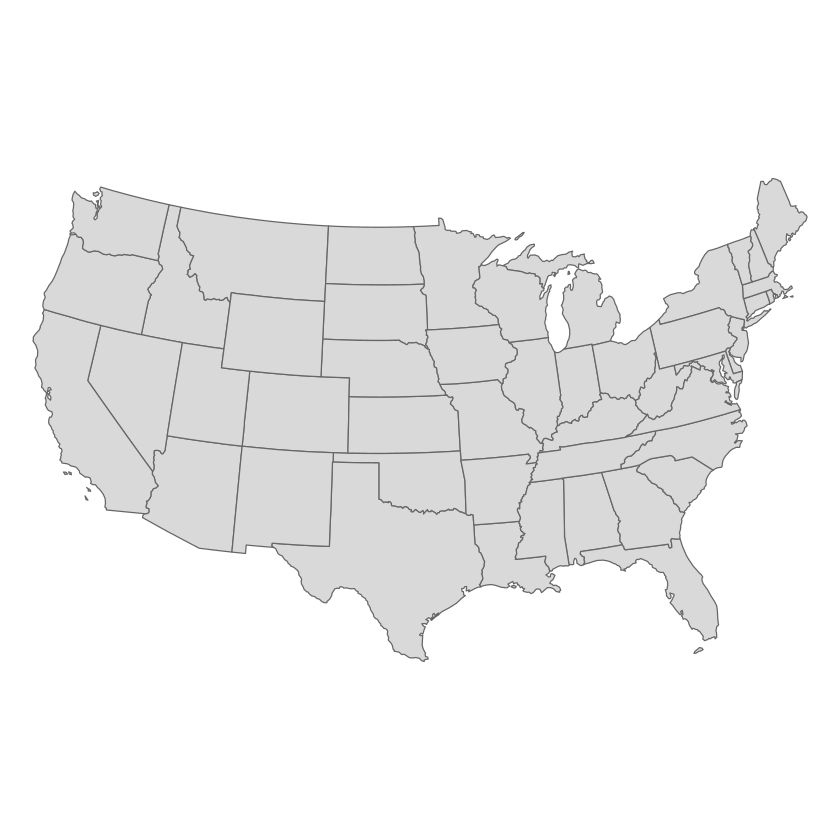

In [68]:
us_states_map = tm_shape(us_states, projection = 2163) + tm_polygons() + 
  tm_layout(frame = FALSE)
us_states_map

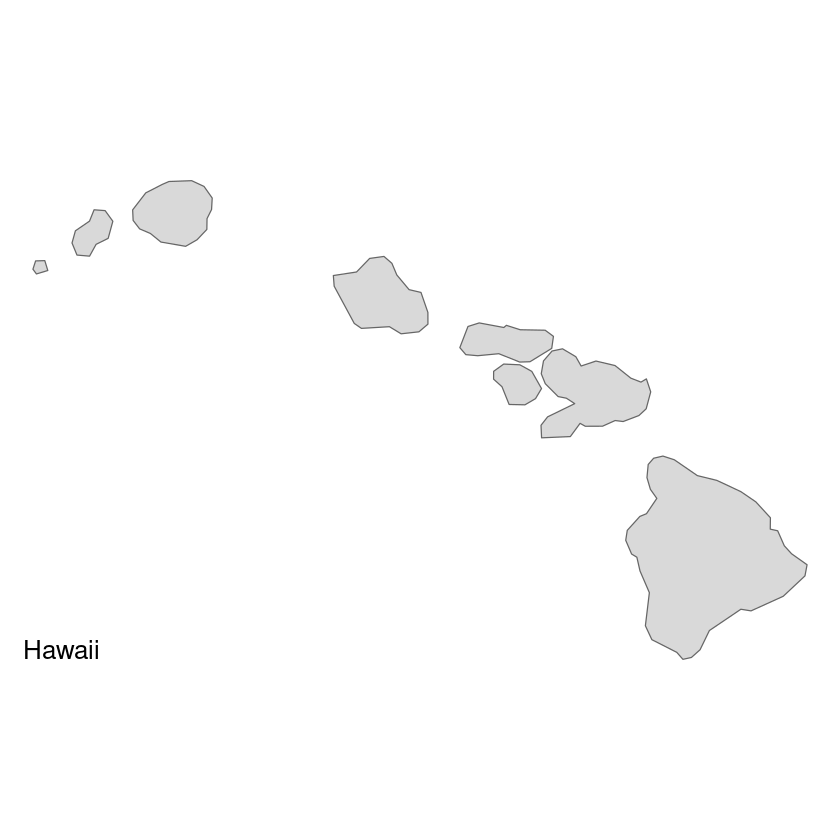

In [69]:
(hawaii_map = tm_shape(hawaii) + tm_polygons() + 
  tm_layout(title = "Hawaii", frame = FALSE, bg.color = NA, 
            title.position = c("LEFT", "BOTTOM")))


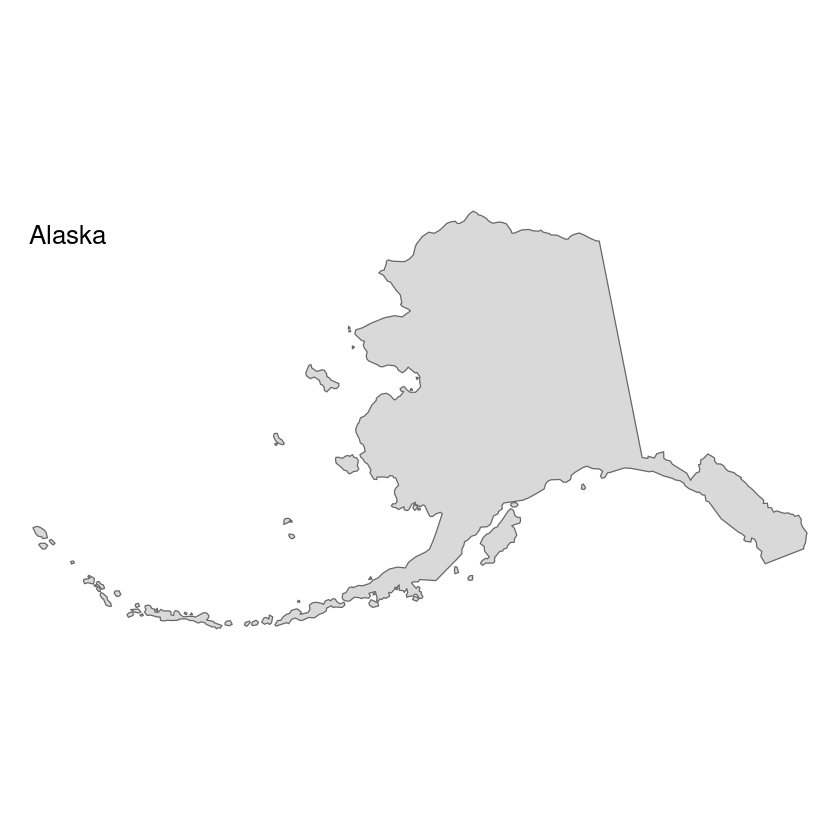

In [70]:
(alaska_map = tm_shape(alaska) + tm_polygons() + 
  tm_layout(title = "Alaska", frame = FALSE, bg.color = NA))

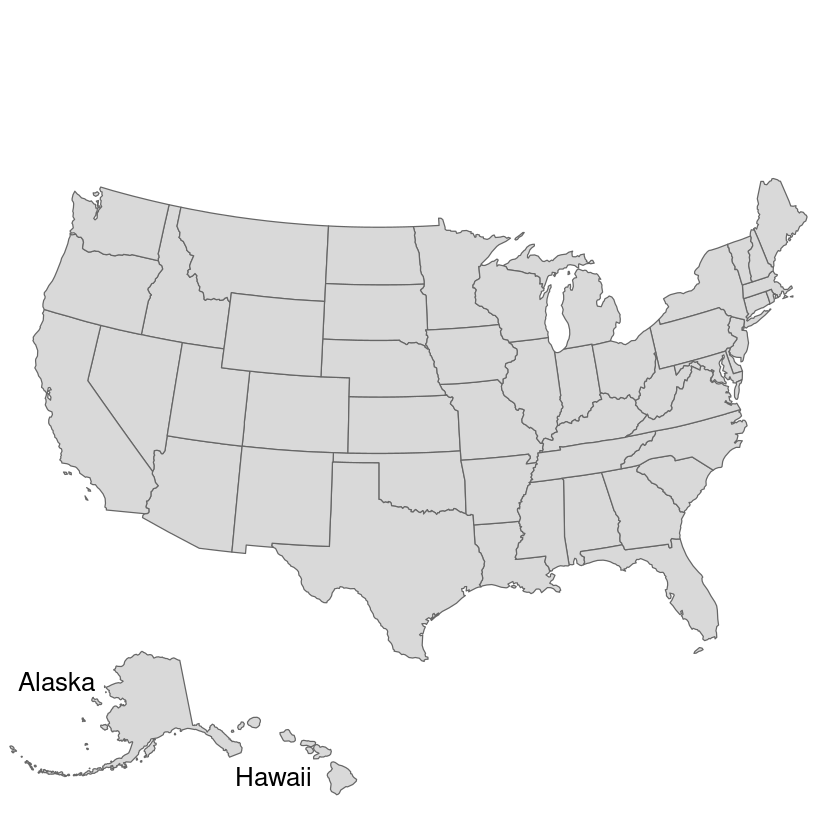

In [71]:
us_states_map
print(hawaii_map, vp = grid::viewport(0.35, 0.1, width = 0.2, height = 0.1))
print(alaska_map, vp = grid::viewport(0.15, 0.15, width = 0.3, height = 0.3))

In [72]:
urb_anim = tm_shape(world) + tm_polygons() + 
  tm_shape(urban_agglomerations) + tm_dots(size = "population_millions") +
  tm_facets(along = "year", free.coords = FALSE)

In [73]:
tmap_animation(urb_anim, filename = "urb_anim.gif", delay = 25)

Creating frames
Creating animation
Animation saved to /home/gjaeger/Insync/nwsja01@cloud.uni-tuebingen.de/OneDrive Biz/shareAcrossMachines/_lehre/ws2122/languageInSpace/session09/urb_anim.gif 


<img src="urb_anim.gif" width="750" align="center">